# Geometrical Calibration of the SOLEIL CRISTAL beamline Croissant Mythen

Authors: 
Jerome Kieffer <kieffer@esrf.eu>, Frederic-Emmanuel Picca <picca@synchrotron-soleil.fr> and Erik Elkaim <elkaim@synchrotron-soleil.fr>

## TODO
- Extract the integration time for each point of the scan.

In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

%load_ext autoreload
%autoreload 2

In [2]:
from typing import Optional
import matplotlib
import math

import h5py
import numpy
import pyFAI

from scipy.signal import find_peaks_cwt
from matplotlib import pyplot
from numpy import arange, arctan, argmin, array, deg2rad, rad2deg, ndarray
from numpy.ma import MaskedArray
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, GeometryRefinement
from pyFAI.peak_picker import ControlPoints, PointGroup

from soleil import *

In [3]:
ROOT = "/nfs/ruche-cristal/cristal-soleil/com-cristal/2018/Run1/99180029_Mythen"
PUBLISHED = os.path.join(ROOT, "published-data")

In [4]:
detector = pyFAI.detectors.detector_factory("Mythen")
base_mask = numpy.zeros(detector.shape, dtype="int8")
base_mask[:20] = 1
base_mask[-20:] = 1
detector.mask = base_mask

In [45]:
def mkFunctions(module: int) -> Functions:
    module_central = 4

    distance = Length(720e-3)  # meter
    poni1 = Length(640 * 50e-6)  # meter
    poni2 = Length(0)  # meter
    rot1_scale, rot1_offset = -1, Angle(60 + (module_central - module) * 5.7)
    rot2_scale, rot2_offset = math.sqrt(abs(rot1_scale**2 - 1)), Angle(0)
    rot3 = Angle(0)
    
    functions = CalibrationFunctions("dist",
                                     "poni1",
                                     "poni2",
                                     "pi*(rot1_scale * tth2C + rot1_offset)/180.0",
                                     "pi*(rot2_scale * tth2C + rot2_offset)/180.0",
                                     "rot3")
    parameters = [ Parameter[Length]("dist", distance, (distance-0.02, distance+0.02)),
                   Parameter[Length]("poni1", poni1, (-0.05, 0.05)),
                   Parameter[Length]("poni2", poni2, (poni2, poni2)),
                   Parameter[float]("rot1_scale", rot1_scale, (rot1_scale, rot1_scale)),
                   Parameter[Angle]("rot1_offset", rot1_offset, (rot1_offset-12, rot1_offset+12)),
                   Parameter[float]("rot2_scale", rot2_scale, (rot2_scale-0.1, rot2_scale+0.1)),
                   Parameter[Angle]("rot2_offset", rot2_offset, (rot2_offset-0.001, rot2_offset+0.001)),
                   Parameter[Angle]("rot3", rot3, (rot3, rot3))
            ]

    return (functions, parameters)

def mkMythenCalibration(filename, calibrant):
    return MythenCalibration(PUBLISHED,
                             filename,
                             calibrant,
                             Wavelength(0.7287e-10),
                             Threshold(1200),
                             [Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.a/frame01"),
                                     mkFunctions(0)),
                              Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.a/frame02"),
                                     mkFunctions(1)),
                              Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.a/frame03"),
                                     mkFunctions(2)),
                              Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.a/frame04"),
                                     mkFunctions(3)),
                              Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.b/frame01"),
                                     mkFunctions(4)),
                              Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.b/frame02"),
                                     mkFunctions(5)),
                              Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.b/frame03"),
                                     mkFunctions(6)),
                              Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.b/frame04"),
                                     mkFunctions(7)),
                              Mythen(DatasetPathWithAttribute("long_name", b"i06-c-c08/dt/mythen.c/frame01"),
                                     mkFunctions(8))],
                              DatasetPathContains("actuator_1_1"),
                              None
                             )

                             #os.path.join(ROOT, "LaB6_17keV_tth2C_24_01_2018_12-04-59_1551.nxs"),
                             #os.path.join(ROOT, "LaB6_17keV_tth2C_24_01_2018_16-02-46_1552.nxs"),

## First exploration of an LaB6 Spectra

The first step is to write a (pixel -> tth) function. We will first describe a perfect geometry. The poni position on the detector `center` will be consider identical on all modules. The direct beam corresponding to the tth2C selected offset (`60 Degrees`) is on the fourth module and will be called `module_central`. The `distance` to the sample is for now identical also for all modules. The expected rotation between each modules is `5.7 Degrees`.

Now we will define a function which allows to display the spectra on each modules.

In [6]:
def plot_mythen(calibration: MythenCalibration,
                modules: Iterable[int]=None,
                xminmax: Tuple[float, float]=None,
                yminmax: Tuple[float, float]=None,
                masked: bool=False):
    """Plot the mythen spectra per modules"""
    if modules is None:
        modules = range(len(calibration.mythens))

    with File(calibration.filename) as f:
        nrows = math.ceil(len(modules) / 3)
        ncols = len(modules) if len(modules) < 3 else 3
        fig, axes = pyplot.subplots(nrows, ncols, sharex=True, sharey=True)
        for frame in gen_metadata_idx_mythen(f, calibration):
            for mi, m in enumerate(modules):
                mythen = frame.mythens[m]
                axis = axes.flat[mi]
                axis.set_title(str(m))
                axis.plot(mythen.tth,
                          mythen.data if masked else mythen.data.data, label=str(m))
                if xminmax is not None:
                    xmin, xmax = xminmax
                    axis.set_xlim(xmin, xmax)
                if yminmax is not None:
                    ymin, ymax = yminmax
                    axis.set_ylim(ymin, ymax)
    return fig
        

def get_mythen_frame(calibration: MythenCalibration,
                     index: int) -> MythenCalibrationFrame:
    with File(calibration.filename) as f:
        for frame in gen_metadata_idx_mythen(f, calibration, indexes=[index]):
            return frame
        
def get_mythen(calibration: MythenCalibration,
               module: int,
               index: int) -> Mythen:
    return get_mythen_frame(calibration, index).mythens[module]

In [46]:
# let's plot all the modules
#lab6 = mkMythenCalibration(os.path.join(ROOT, "LaB6_17keV_tth2C_24_01_2018_16-39-43_1554.nxs"),
#                           Calibrant("LaB6"))
lab6 = mkMythenCalibration(os.path.join(ROOT, "LaB6_17keV_att3_tth2C_24_01_2018_19-43-20_1555.nxs"),
                           Calibrant("LaB6_SRM660a"))

<IPython.core.display.Javascript object>


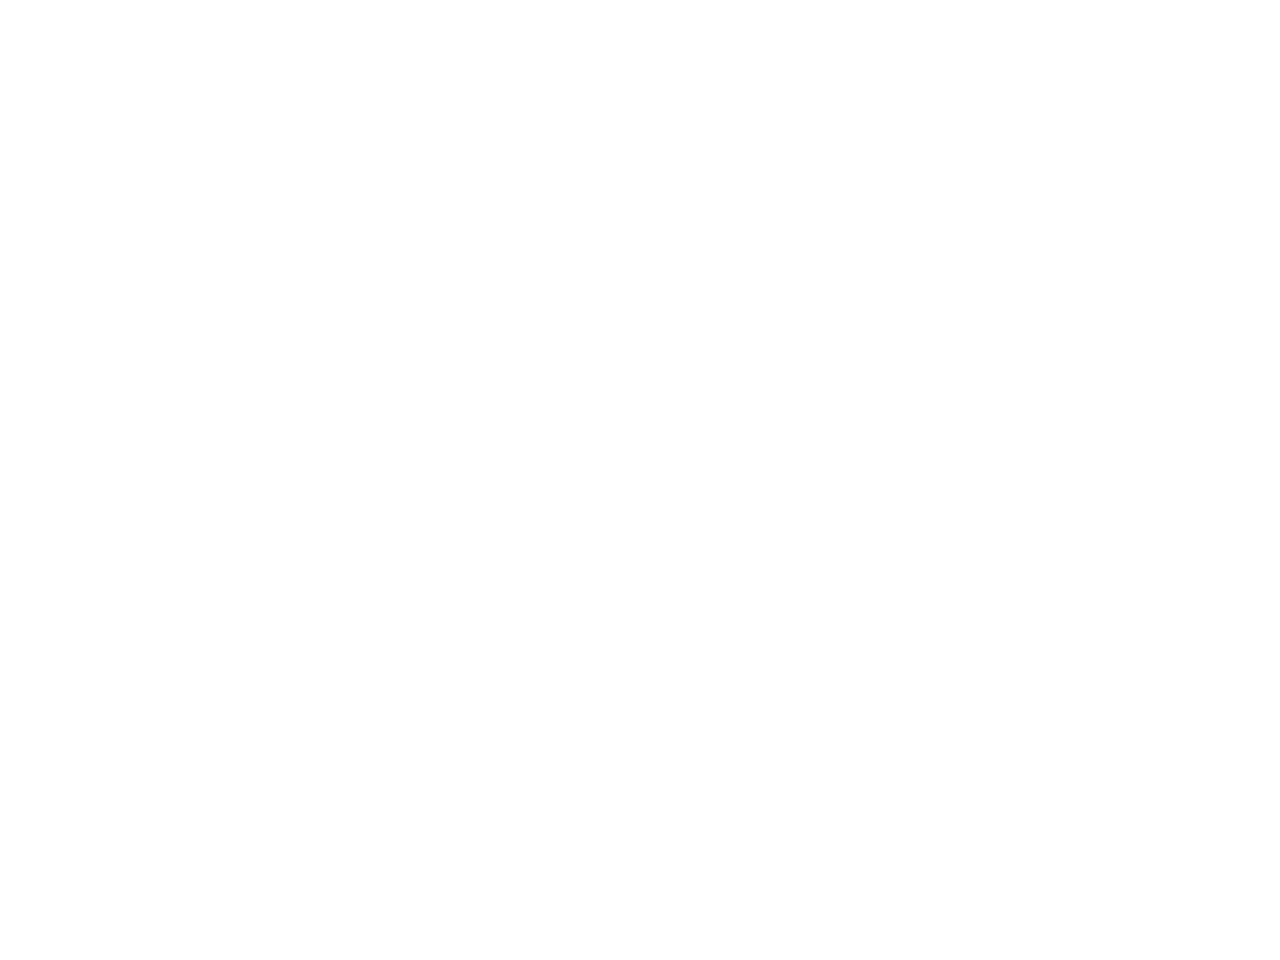

<IPython.core.display.Javascript object>


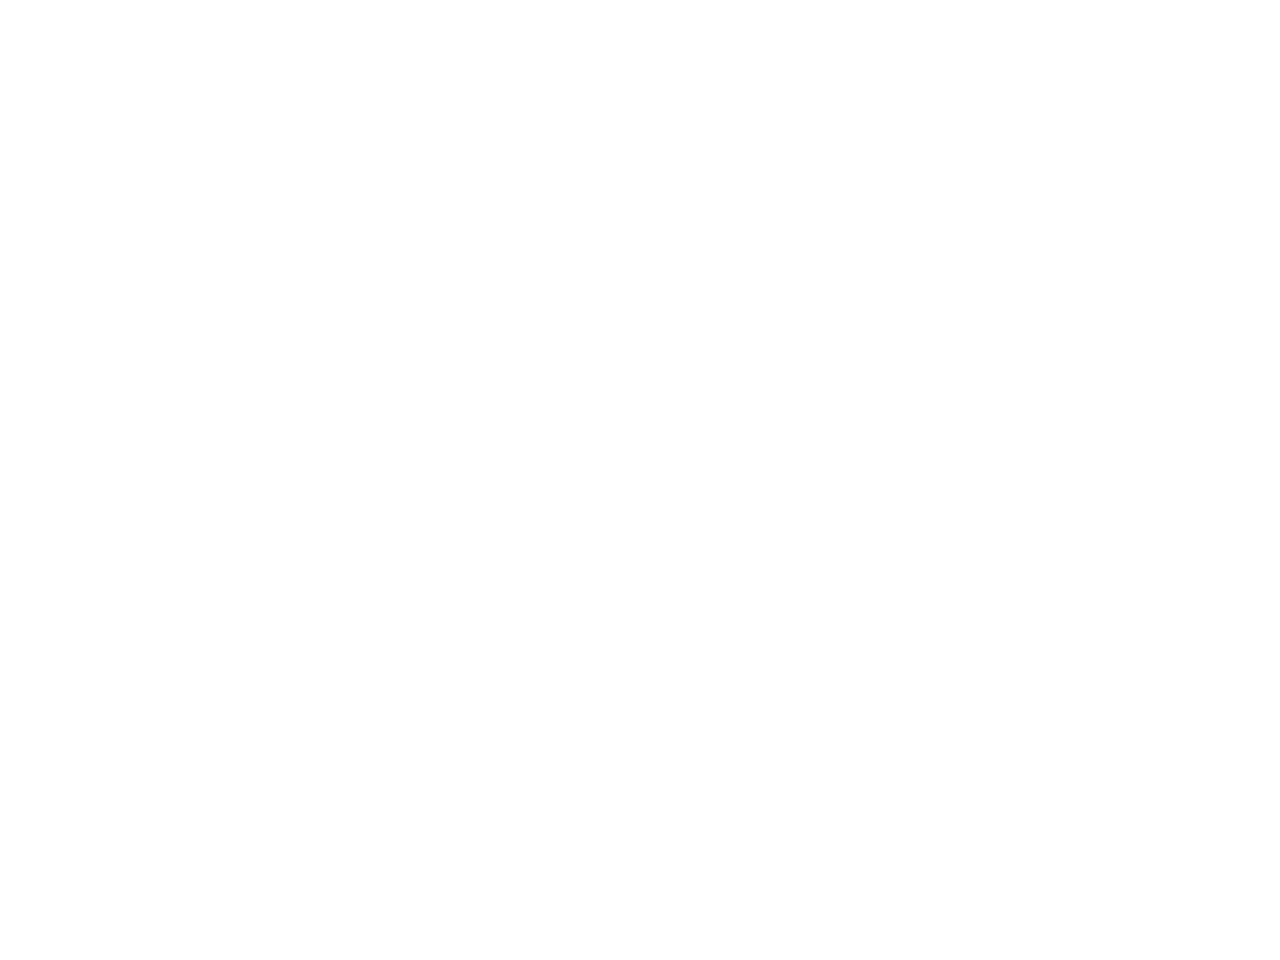

In [8]:
plot_mythen(lab6)

First the tth function is almost ok, we recognize the LaB6 specta.
Nevertheless, let's look closer to the maximum peak.

<IPython.core.display.Javascript object>


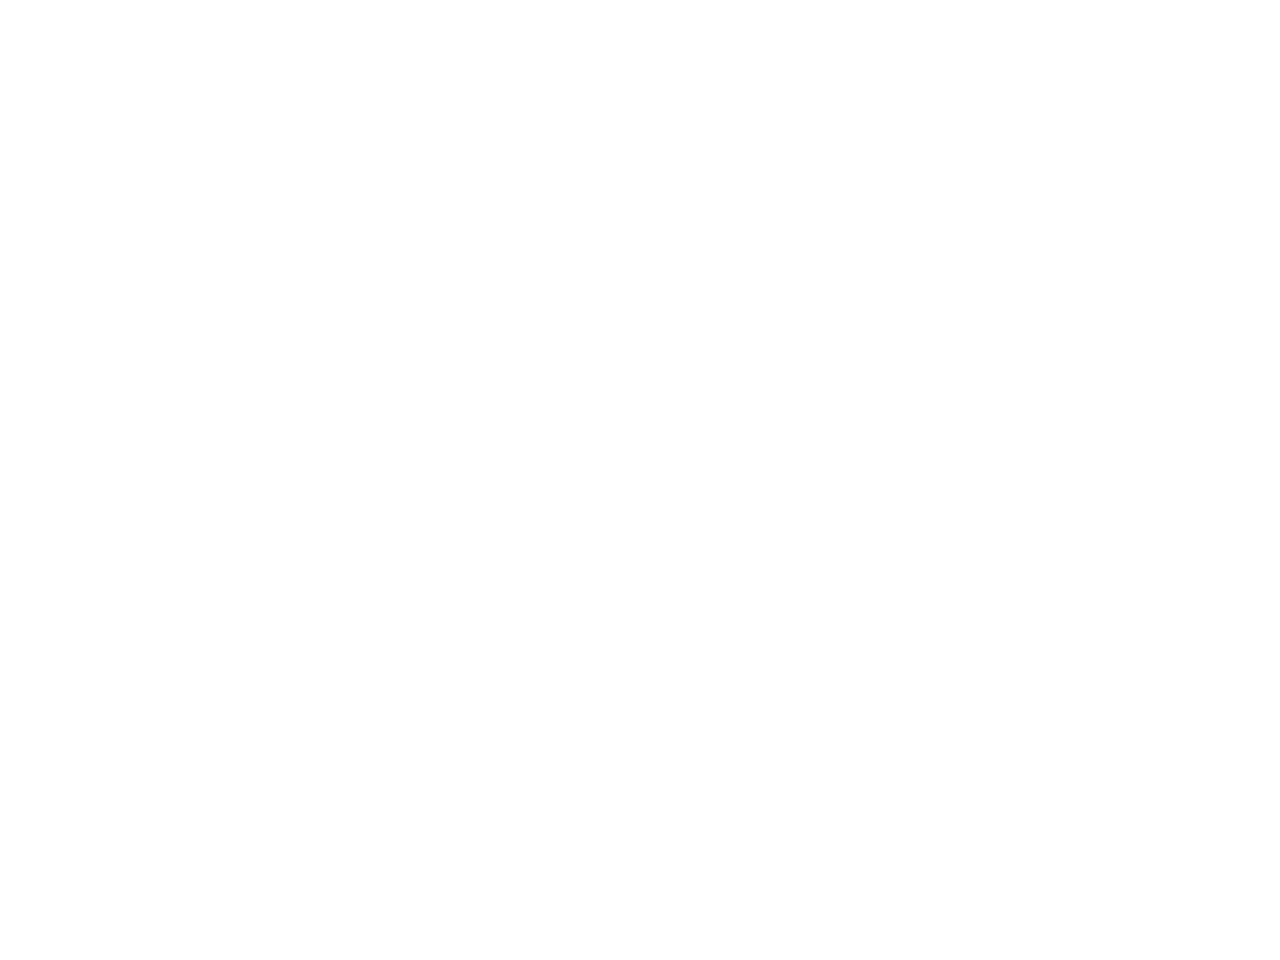

<IPython.core.display.Javascript object>


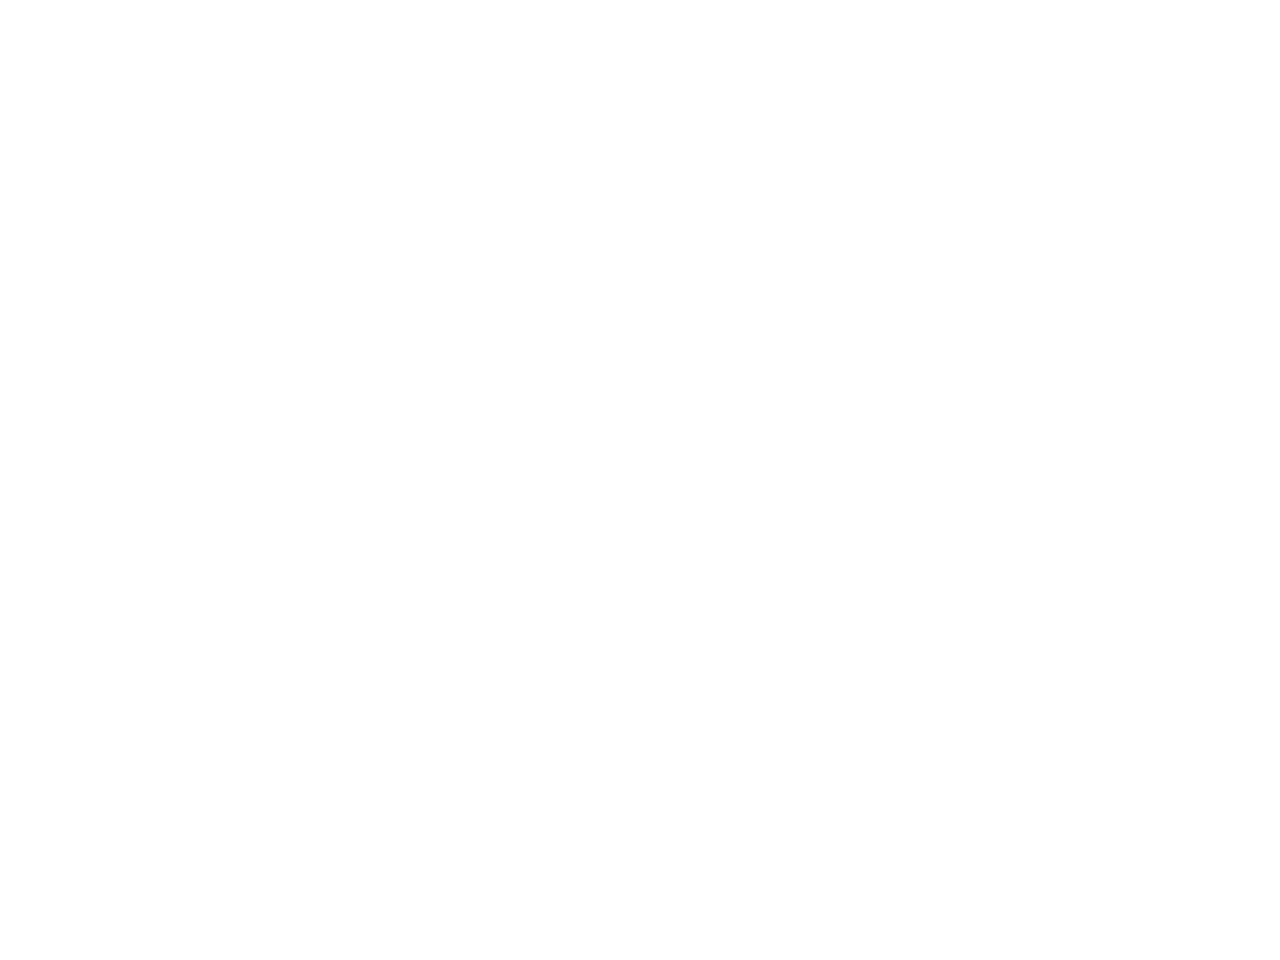

In [9]:
plot_mythen(lab6, xminmax=(-14.95, -14.85))

Now we see that the x coordinates are wrong. The peak should be located at the same position for each module. Another problem observed is that sometime peak are completly off on the same module.

## Let's work now with Silicon.

<IPython.core.display.Javascript object>


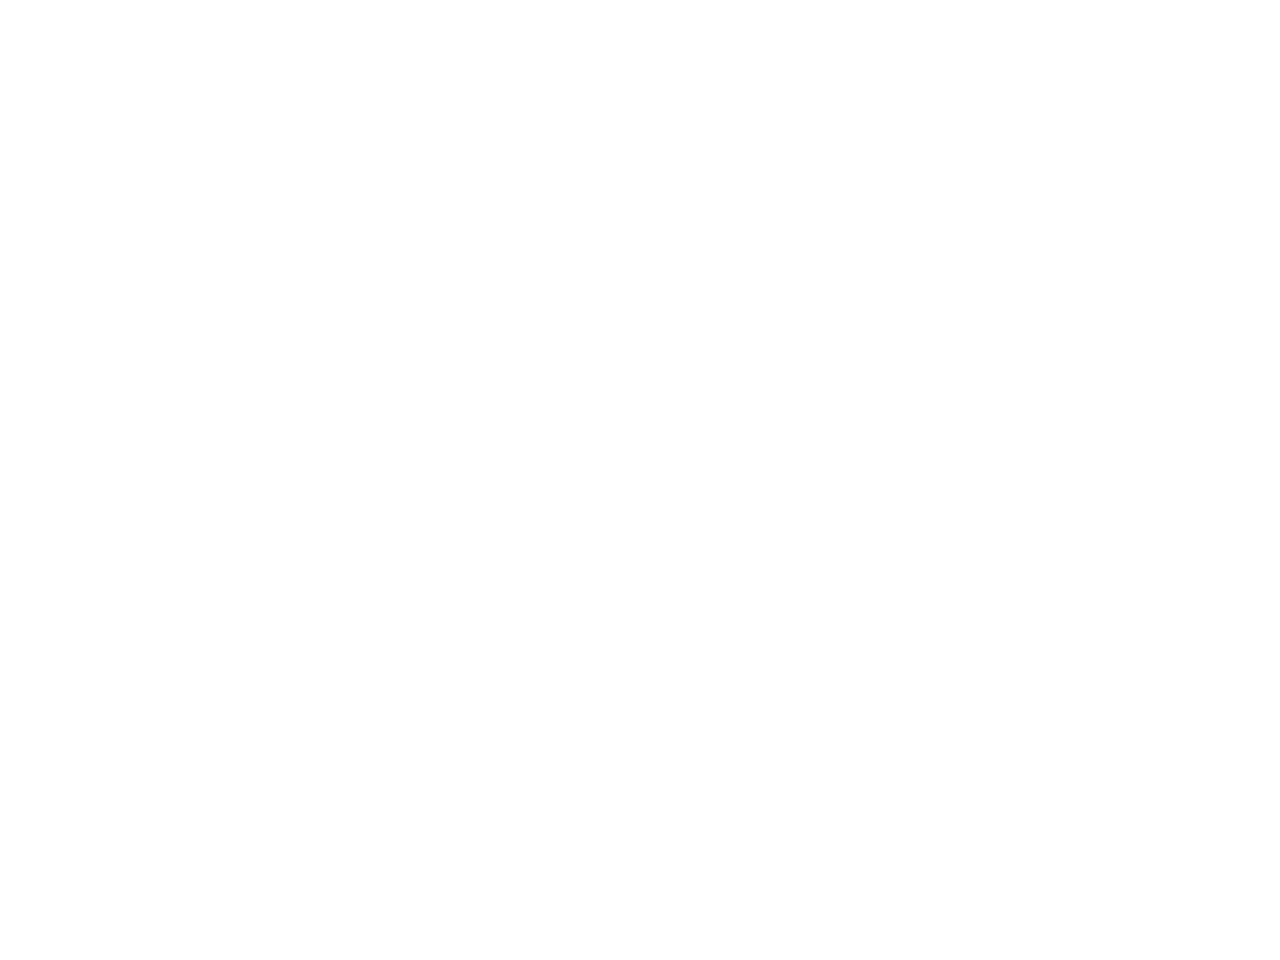

<IPython.core.display.Javascript object>


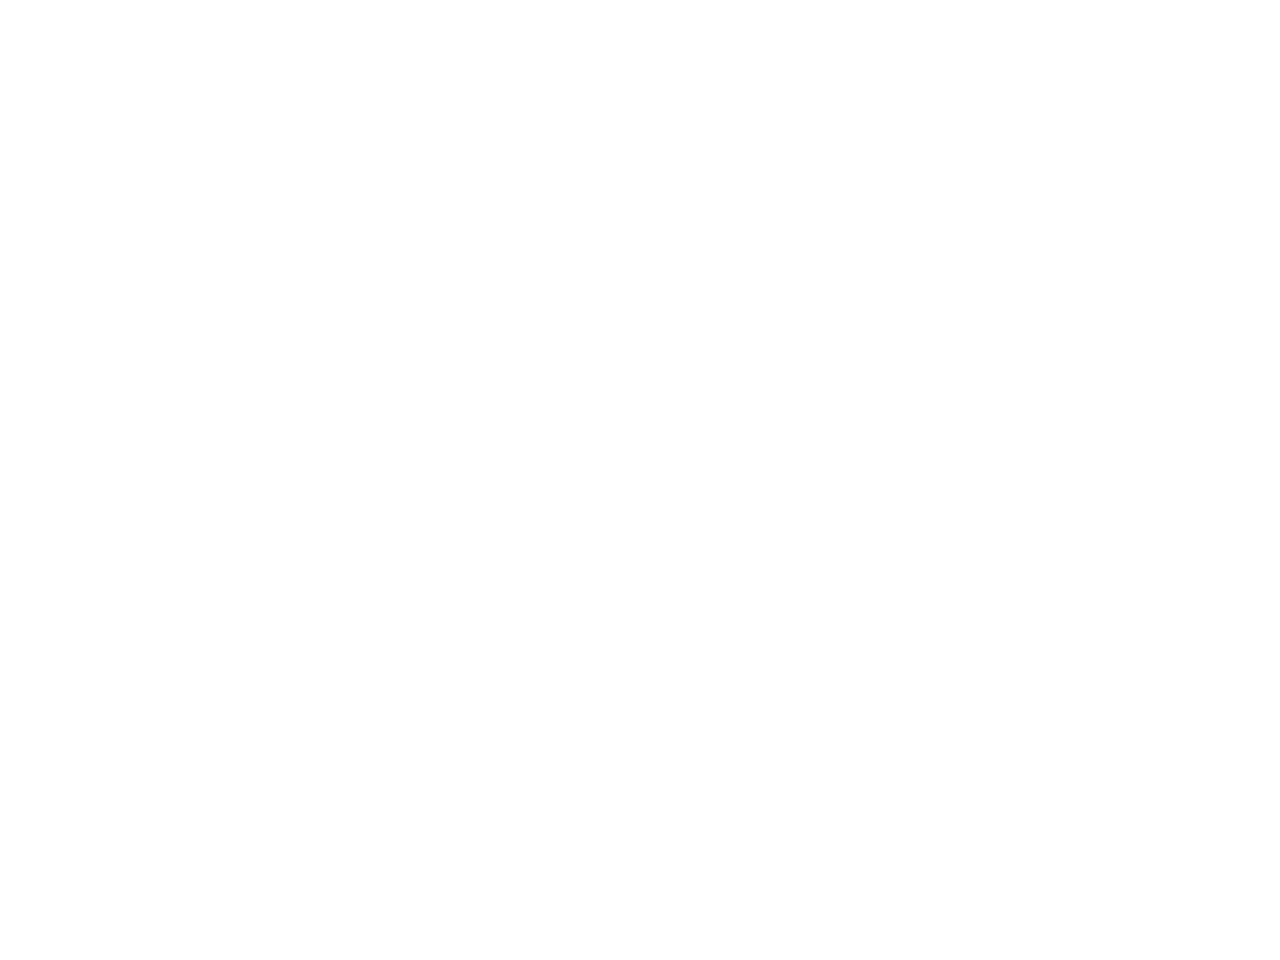

In [10]:
si = mkMythenCalibration(os.path.join(ROOT, "Si_17keV_att3_tth2C_25_01_2018_12-38-53_1557.nxs"),
                         Calibrant("Si"))

plot_mythen(si, modules=(0, 1), xminmax=(-13.36, -13.21))

<IPython.core.display.Javascript object>


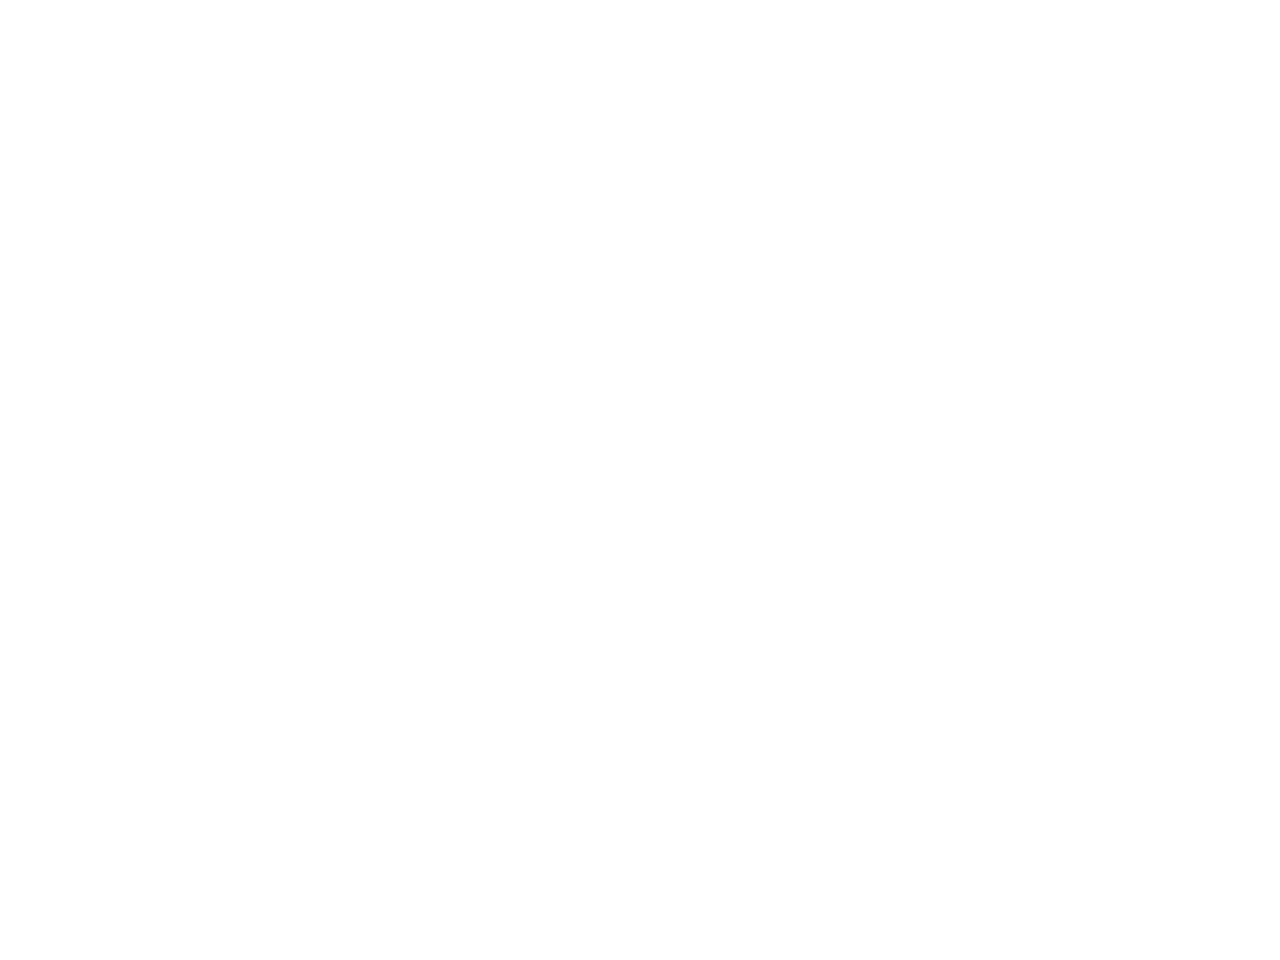

<IPython.core.display.Javascript object>


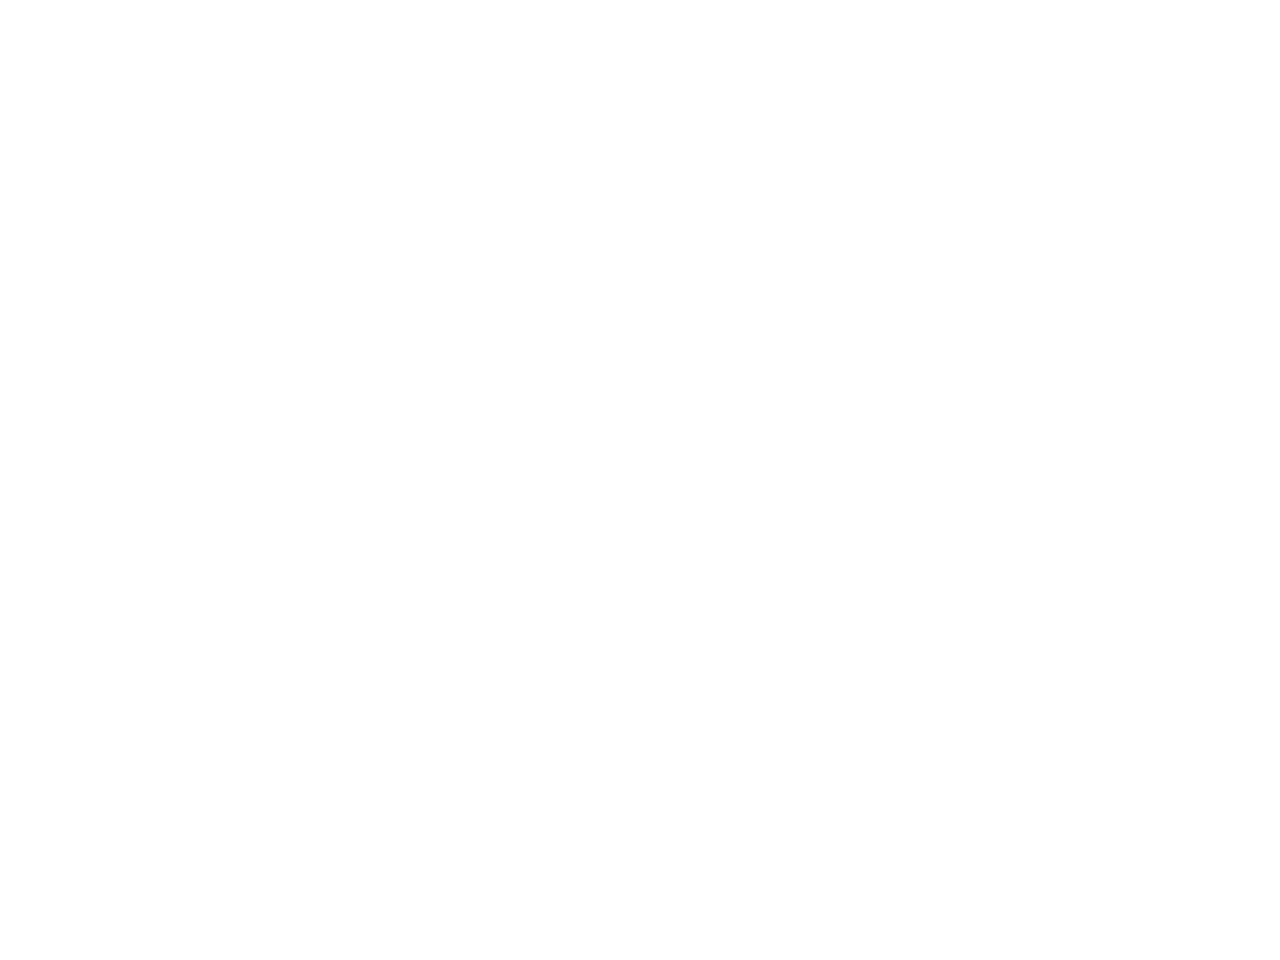

In [11]:
plot_mythen(si, modules=(5,6), xminmax=(13.3, 13.45))

<IPython.core.display.Javascript object>


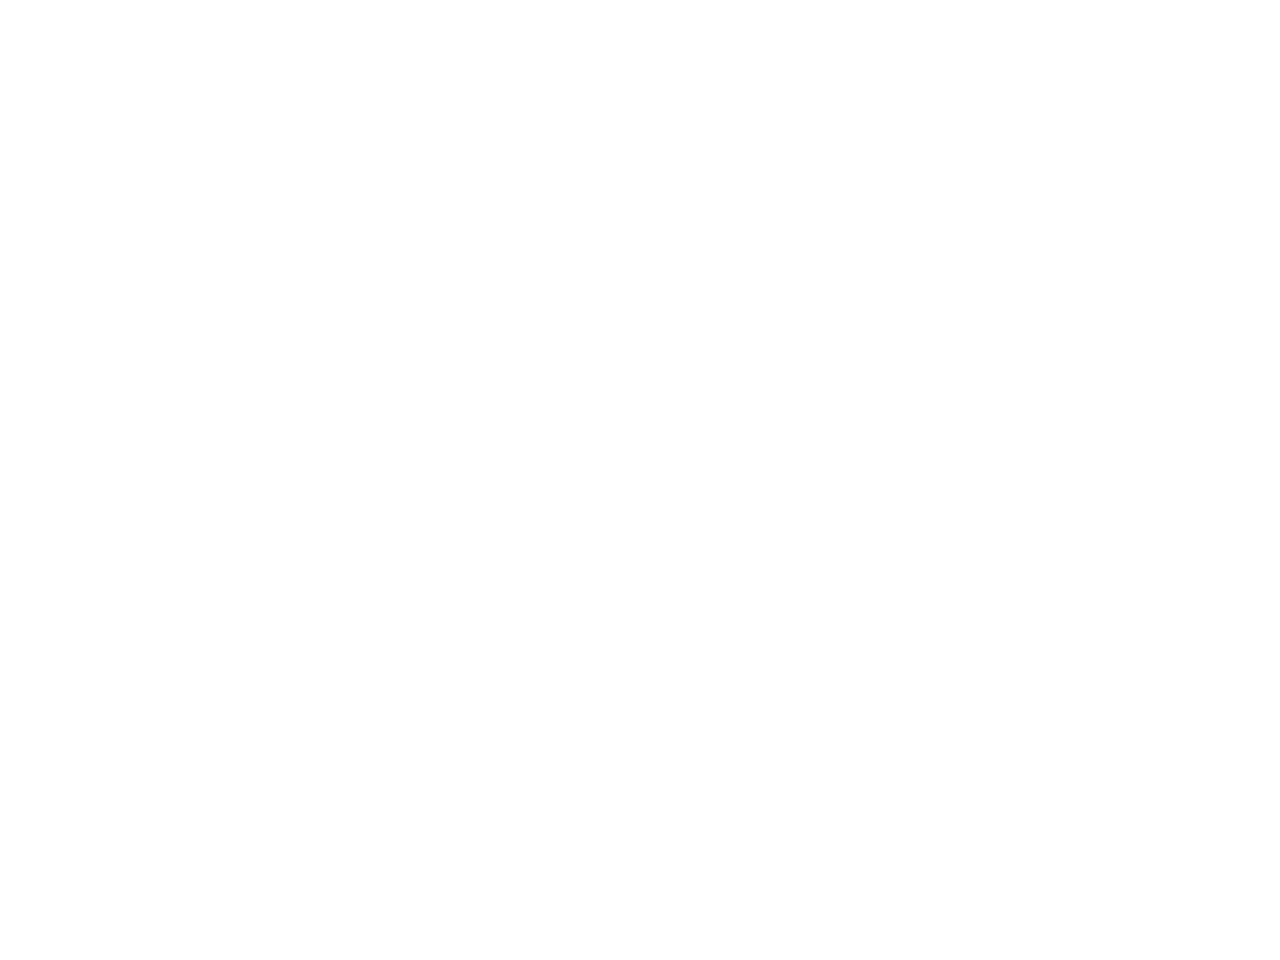

<IPython.core.display.Javascript object>


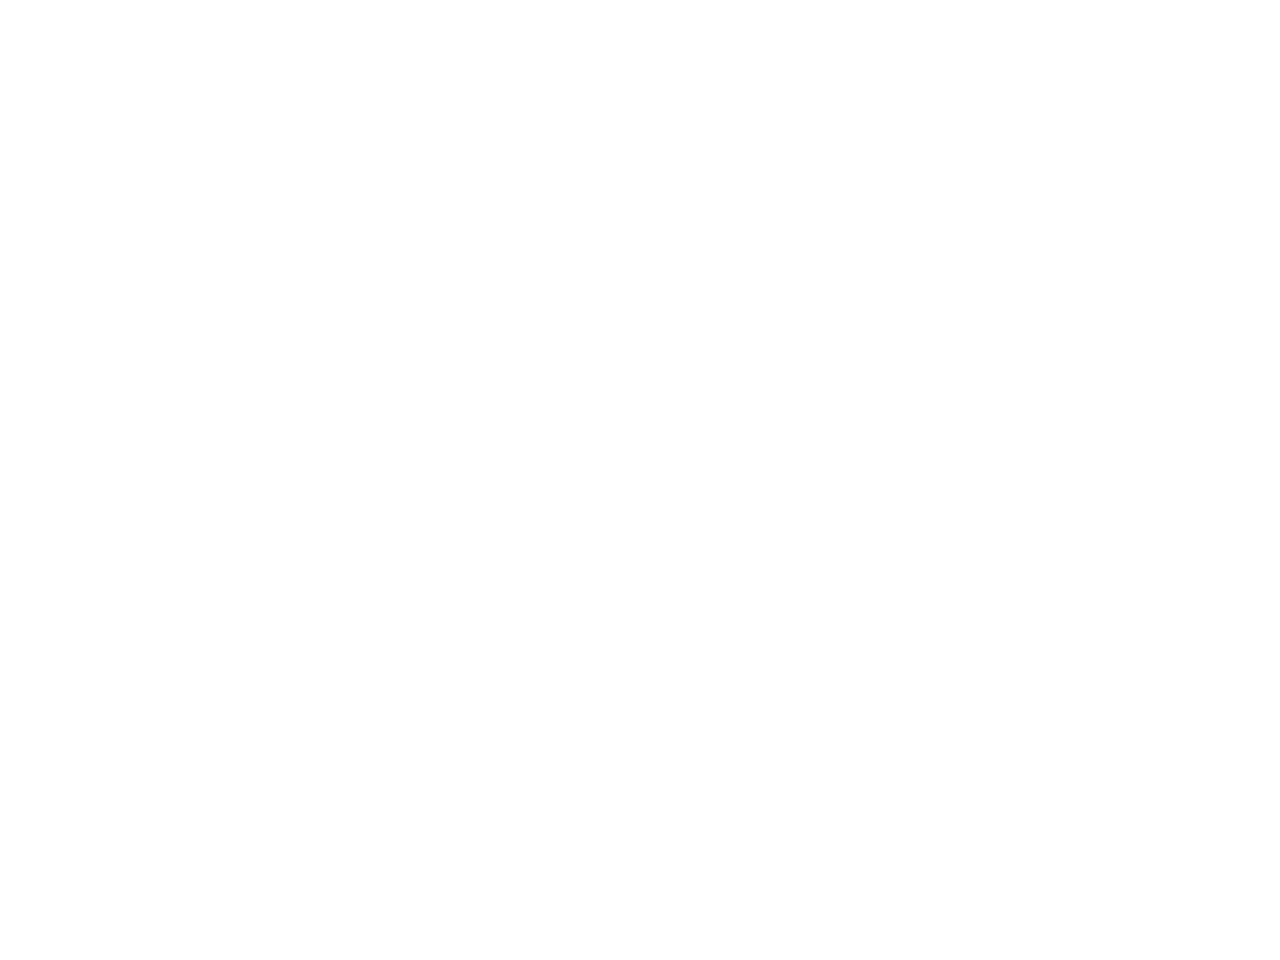

In [12]:
plot_mythen(si, modules=(7, 8), xminmax=(25.65, 25.85))

TODO
- Compute the bad pixels spreading...

## Flat exploration



<IPython.core.display.Javascript object>


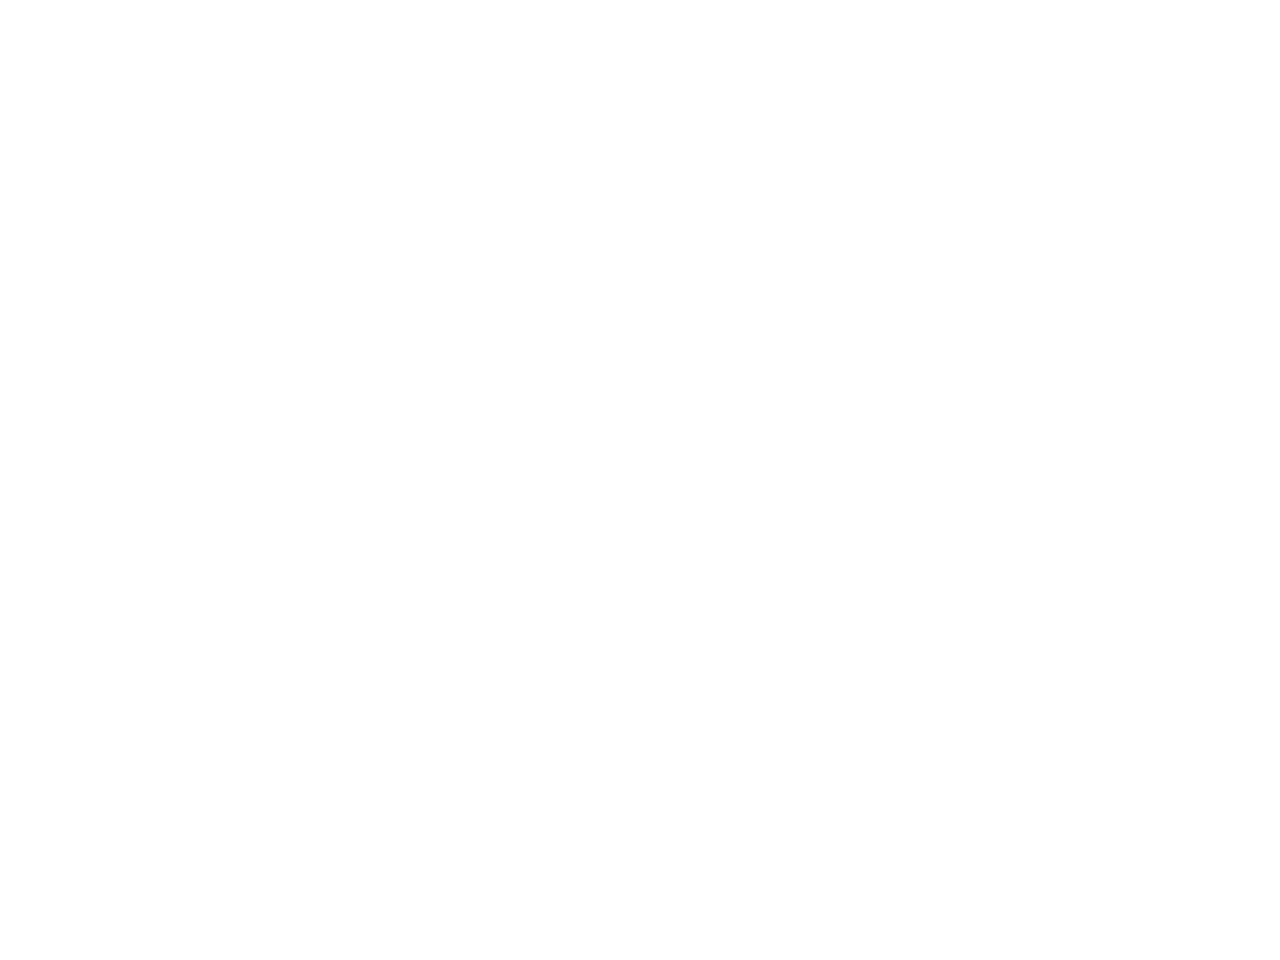

<IPython.core.display.Javascript object>


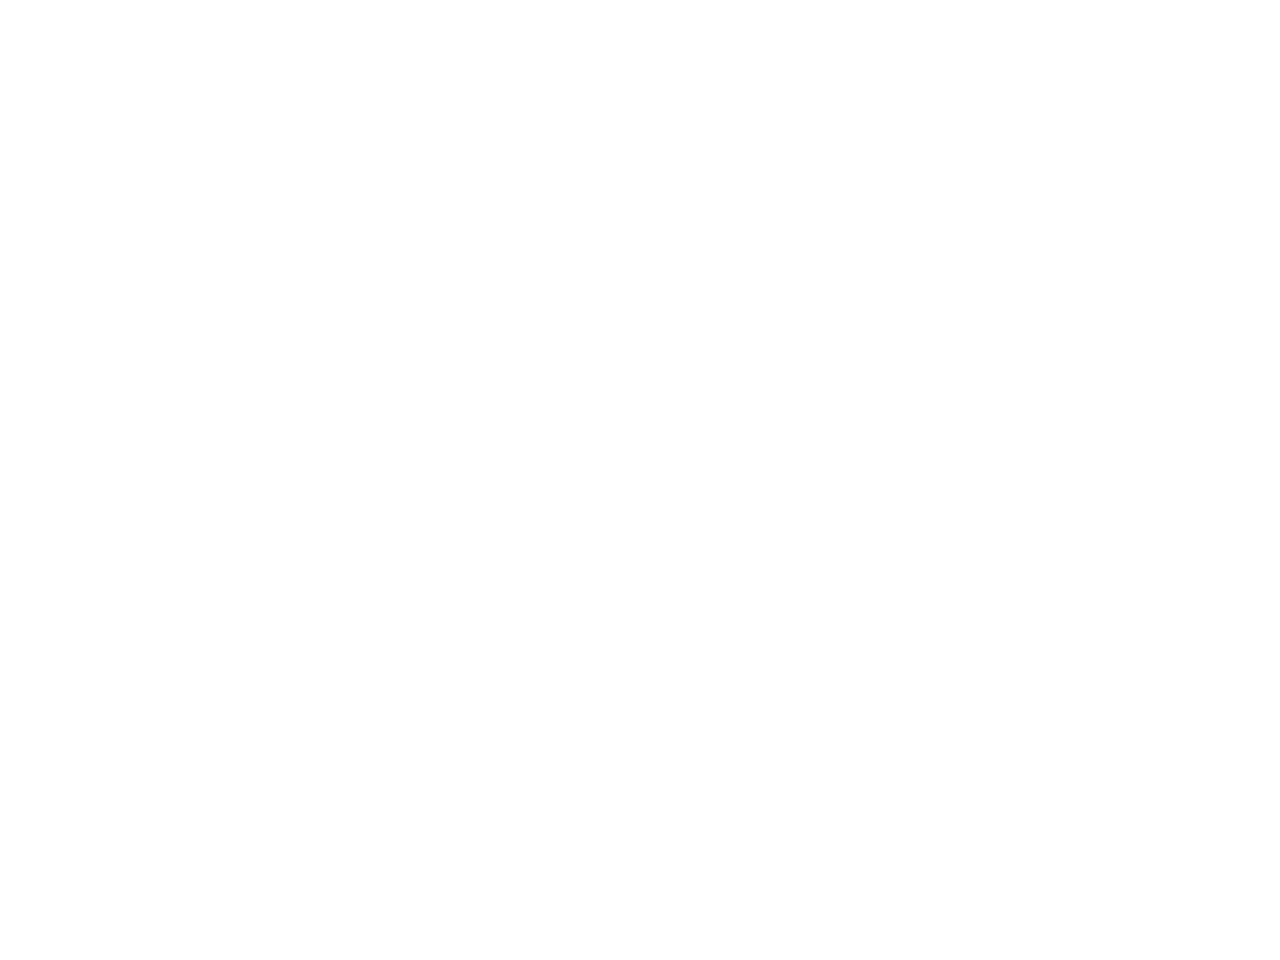

In [13]:
glass = mkMythenCalibration(os.path.join(ROOT, "Verre_17keV_tth2C_26_01_2018_12-15-57_1573.nxs"),
                            None)

plot_mythen(glass, masked=True)

<IPython.core.display.Javascript object>


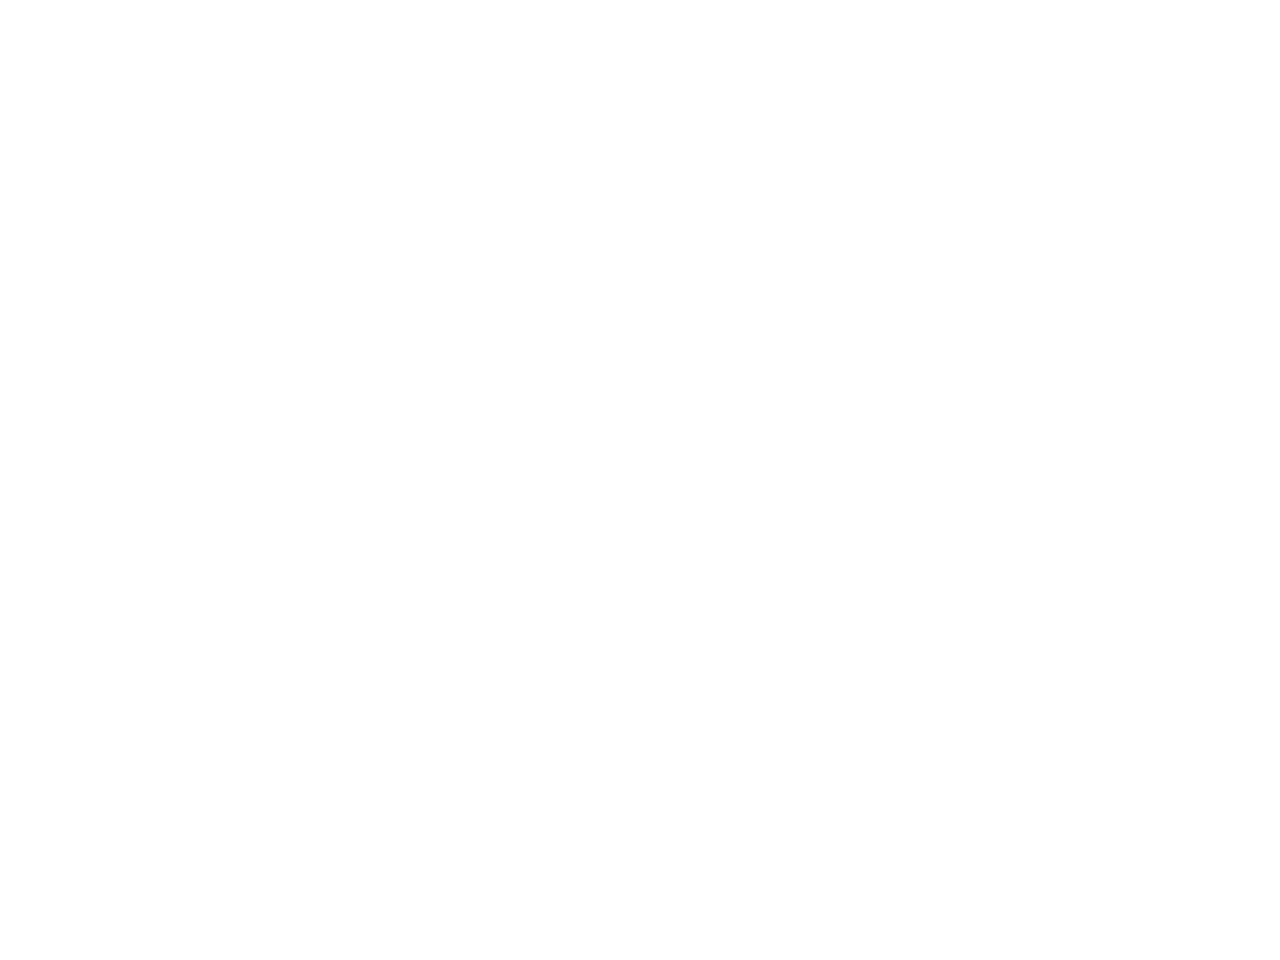

<IPython.core.display.Javascript object>


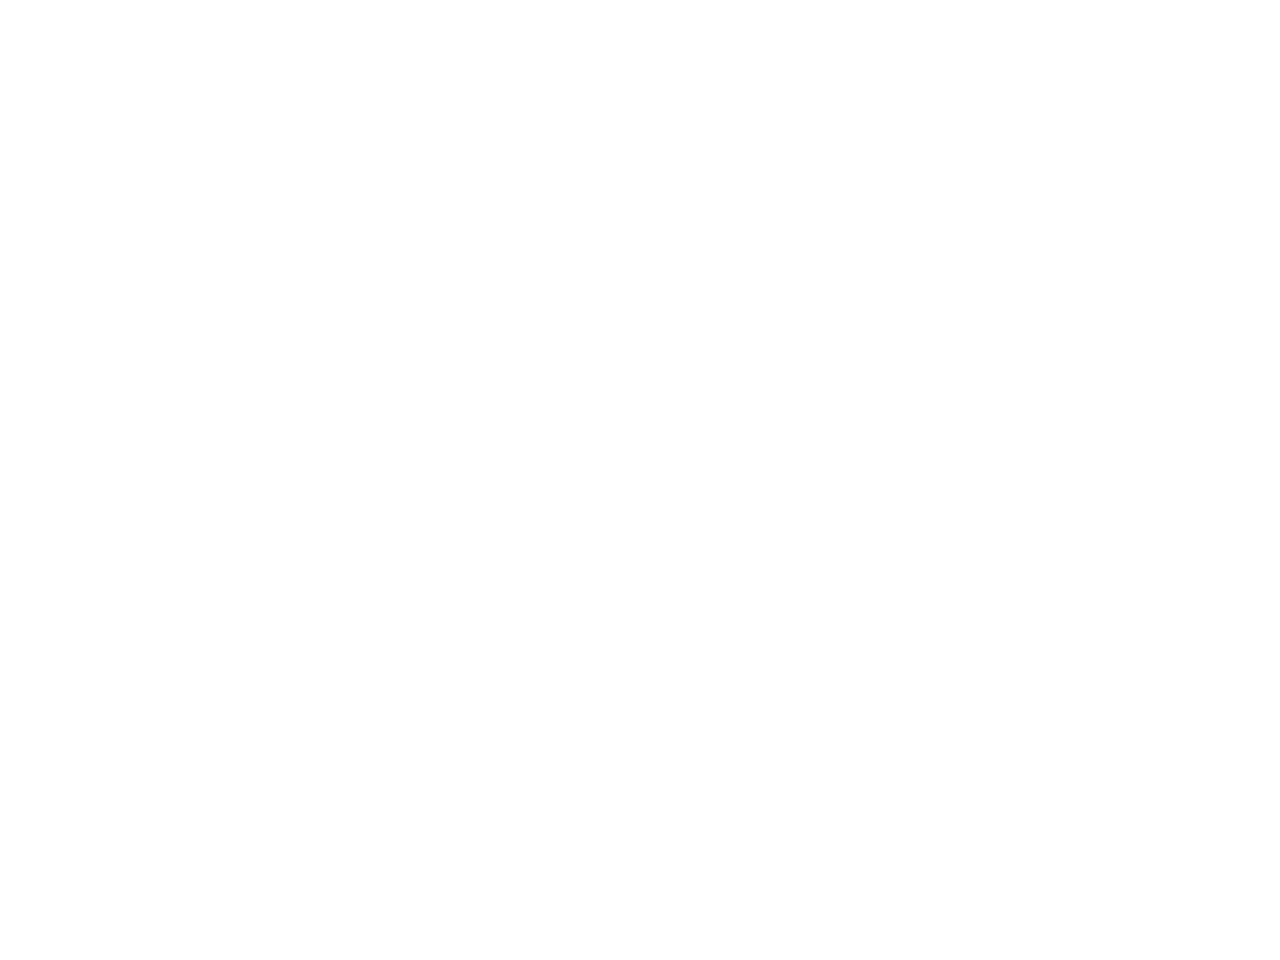

In [14]:
glass2 = mkMythenCalibration(os.path.join(ROOT, "Verre_flat_17keV_tth2C_26_01_2018_14-49-45_1576.nxs"),
                             None)

plot_mythen(glass2, masked=True, xminmax=(-60, -54.5), yminmax=(145000, 173000))

Let's plot the ration of two identical acquisitions with no flat corrections activated in the device, in order to compute the Detector noise.

<IPython.core.display.Javascript object>


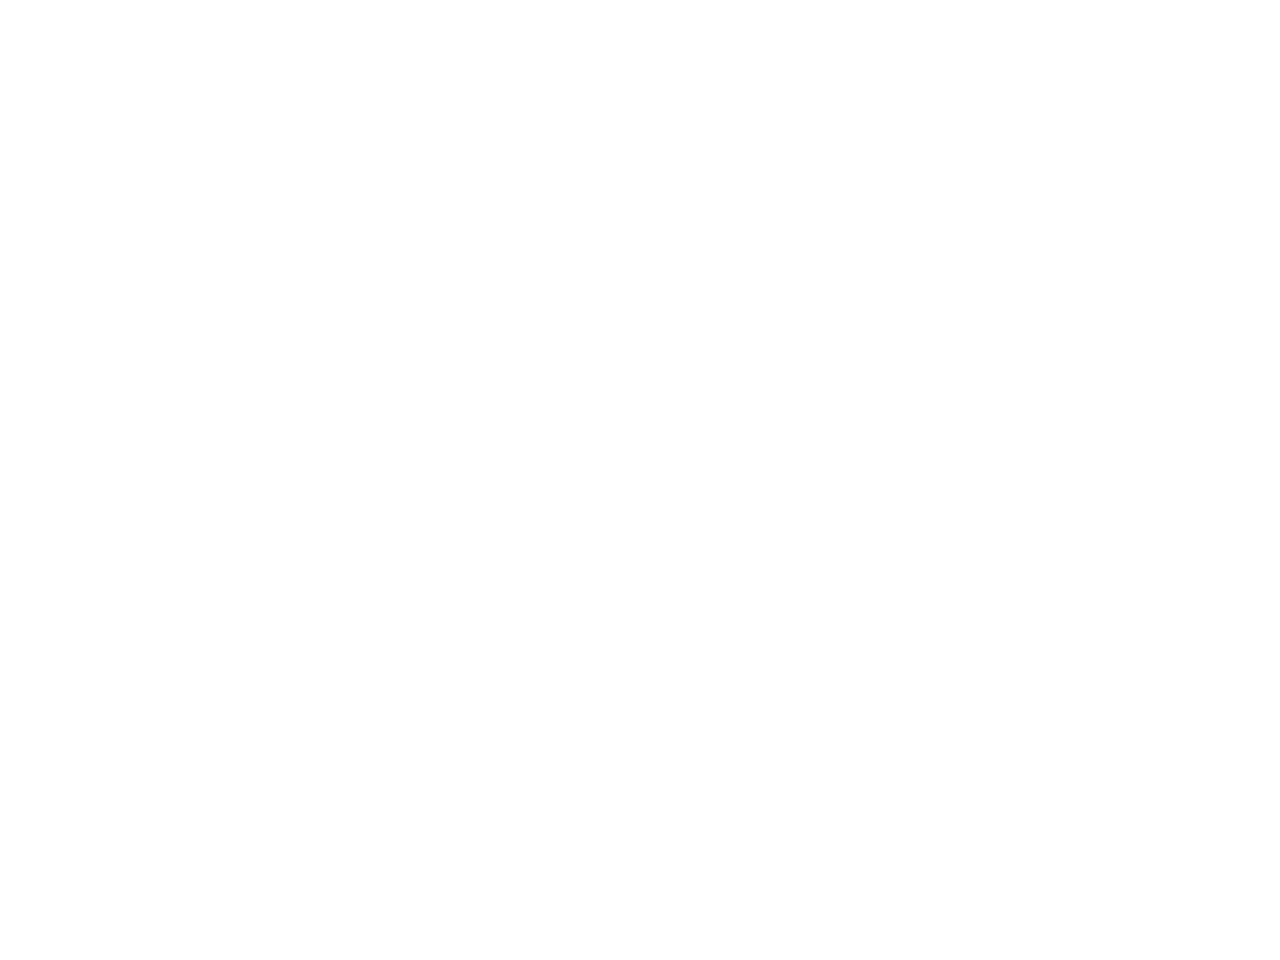

In [15]:
glass3 = mkMythenCalibration(os.path.join(ROOT, "Verre_flat_17keV_tth2C_26_01_2018_16-22-23_1577.nxs"),
                             None)

def plot_spectra_ratio(im1: MythenCalibration,
                       im2: MythenCalibration,
                       module: int, index:int,
                       masked: bool=True,
                       expo1: float=1.0,
                       expo2: float=1.0) -> None:
    m1 = get_mythen(im1, module, index)
    m2 = get_mythen(im2, module, index)
    fig, axis = pyplot.subplots()
    data = (m1.data / expo1) / (m2.data / expo2)
    sigma = numpy.std(data)
    axis.plot(m1.tth, data if masked else data.data)
    axis.set_title("module: {:d}, index: {:d}, sigma: {:f}".format(module, index, sigma))

plot_spectra_ratio(glass2, glass3, 2, 2)

<IPython.core.display.Javascript object>


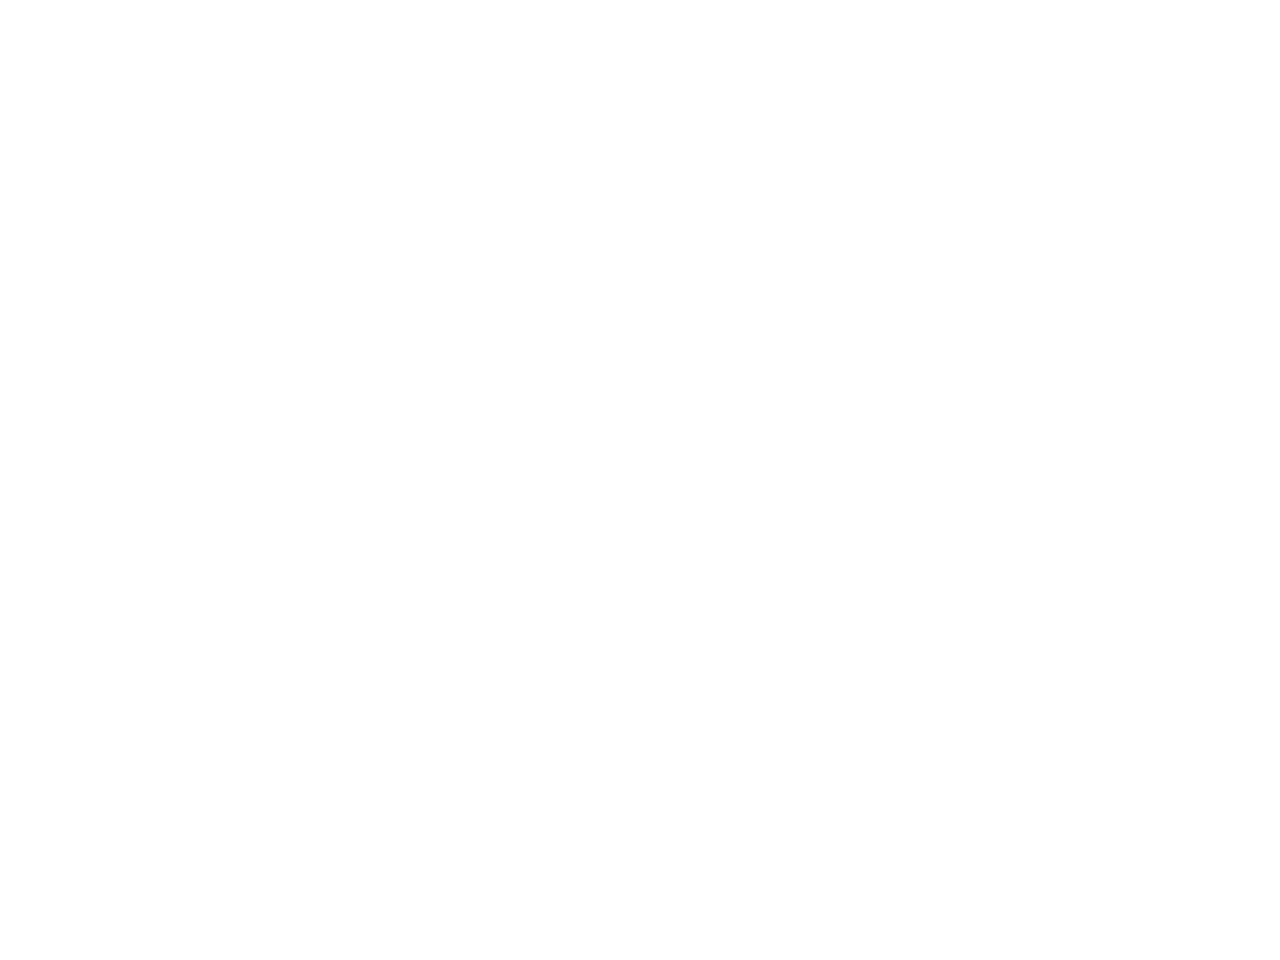

In [16]:
glass4 = mkMythenCalibration(os.path.join(ROOT, "Verre_flat_17keV_tth2C_26_01_2018_17-18-55_1578.nxs"), None)
glass5 = mkMythenCalibration(os.path.join(ROOT, "Verre_flat_17keV_tth2C_26_01_2018_17-27-23_1579.nxs"), None)

plot_spectra_ratio(glass4, glass5, 2, 2)

<IPython.core.display.Javascript object>


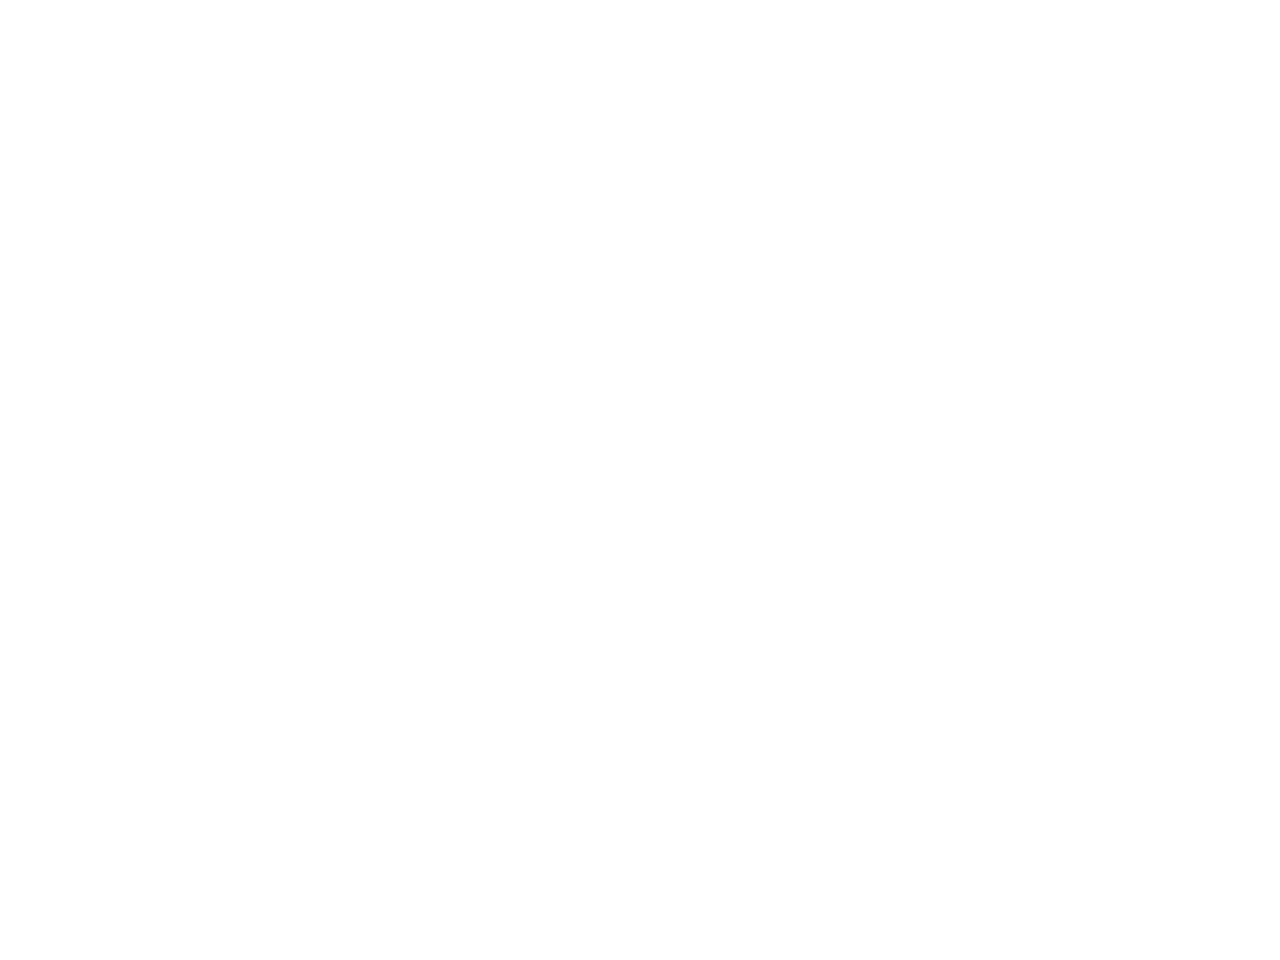

<IPython.core.display.Javascript object>


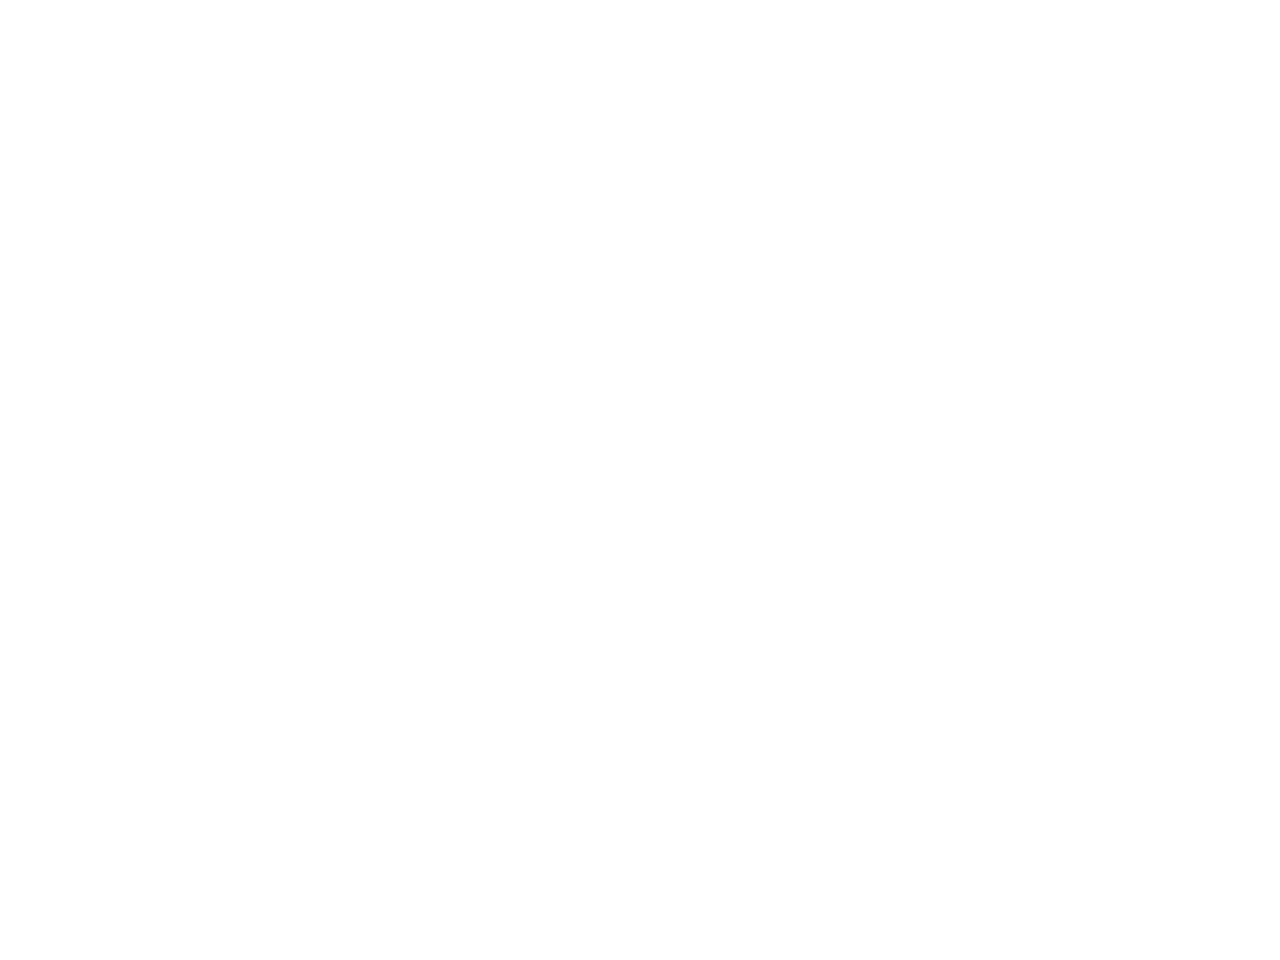

In [17]:
plot_spectra_ratio(glass2, glass4, 2, 2, expo1=120, expo2=12)
plot_spectra_ratio(glass2, glass5, 2, 2, expo1=120, expo2=12)

In [18]:
math.sqrt(150000) / 150000 * 3

0.007745966692414834

TODO:

pour un pas donne et pour un module donne, on suppose que si la mechanique est parfaite, la distance entre le poni et l'echantillon est de 720 mm. De plus le poni doit etre le centre du module.
Le decalage en angle du module est egalement connu.

In [19]:
# first LaB6 peak for scan 74 on module mythena01 around 1241
# first LaB6 peak for scan 75 on module mythena01 around 1190

## find peaks on modules

In [20]:
def find_peaks(data: MaskedArray,
               threshold: Threshold,
               tth2C: float,
               module: int,
               calibrant: pyFAI.calibrant.Calibrant, 
               rings: Optional[List[int]]=None) -> List[Peak]:
    widths = array([20])  # function parameter ?
    
    positions = find_peaks_cwt(data, widths)
    
    # compute the tth position, really inefficent for now
    tths_peak = deg2rad(mythenTth(tth2C, module, positions))

    # compute the theoretical tth angles.
    tths_cal = calibrant.get_2th()

    peaks = []  # List[Peak]
    for i, tth_peak in zip(positions, tths_peak):
        if data[i] > threshold and data.mask[i] is not True:
            if tth_peak > 0:
                continue
            ring = argmin(abs(tths_cal - abs(tth_peak)))
            if rings is not None:
                if ring not in rings:
                    continue
            peak = Peak(i, data[i], tth_peak, ring)
            peaks.append(peak)

    return peaks

def plot_peaks(im1: MythenCalibration,
               module: int,
               index: int,
               threshold: Optional[Threshold]=None) -> None:

    frame = get_mythen_frame(im1, index)
    mythen = frame.mythens[module]
    calibrant = get_calibrant(im1.calibrant, im1.wavelength)
    threshold = threshold or im1.threshold
    peaks = find_peaks(mythen.data, threshold, frame.tth2C, module, calibrant, im1.rings)

    fig, ax = pyplot.subplots()
    ax.set_title("found {} peak(s)".format(len(peaks)))
    ax.plot(mythen.data)
    for peak in peaks:
        ax.annotate(peak.index, xy=(peak.position, peak.intensity),
                    arrowprops=dict(facecolor='black', shrink=0.05))

Let's find peaks close to the beamstop.

<IPython.core.display.Javascript object>


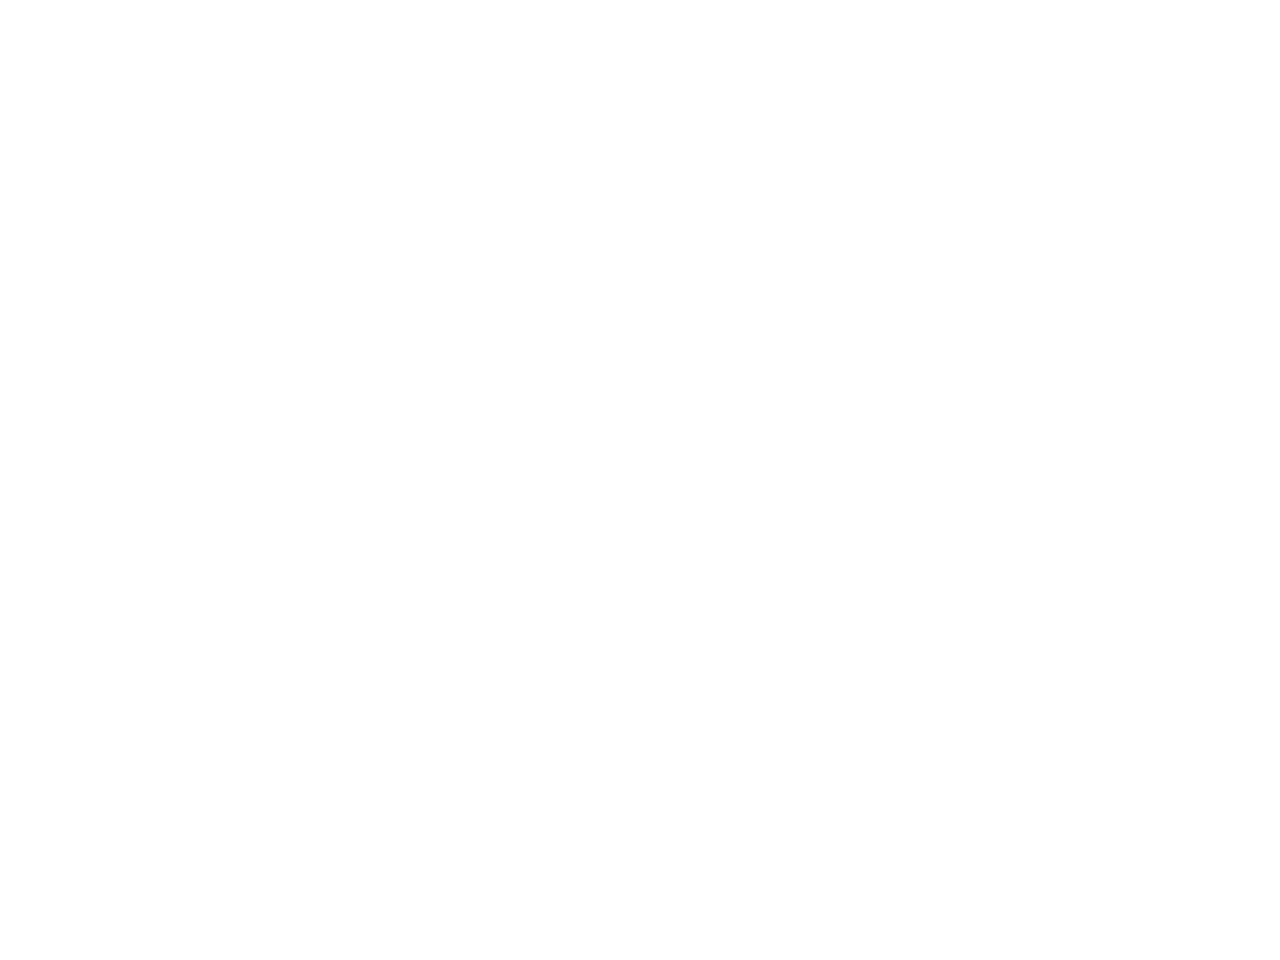

In [21]:
plot_peaks(lab6, module=0, index=30, threshold=Threshold(1200))

It is clear that this is wrong. It is necessary to use another paramerterin order to discriminate nois and peaks. At first we will use the mesured intensity to discriminate.

First let's see real peaks.

<IPython.core.display.Javascript object>


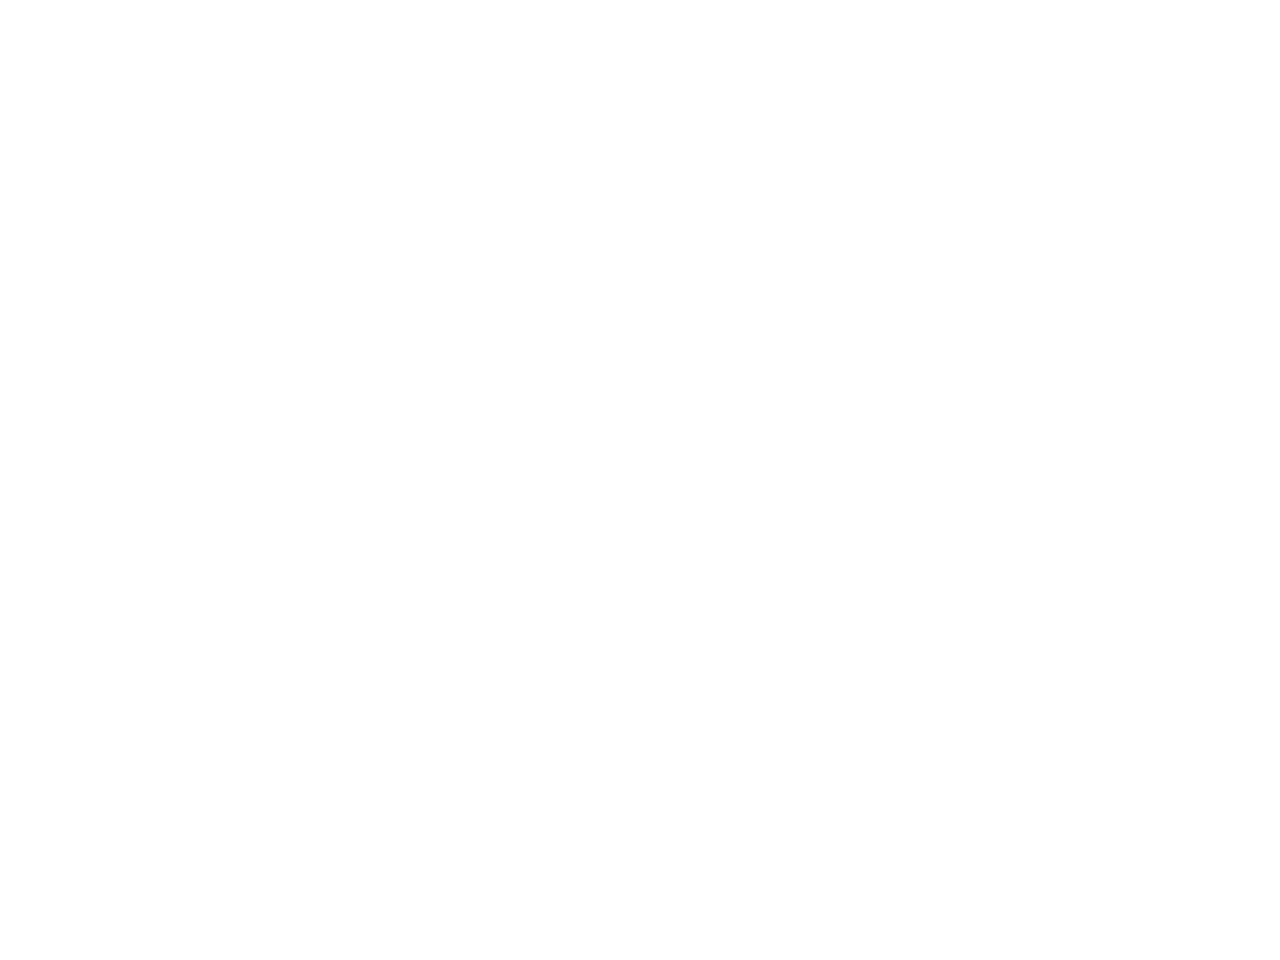

In [22]:
plot_peaks(lab6, module=0, index=200, threshold=Threshold(1200))

It is clear that we can use a threshold around 10000 in order to avoid our initial problem.

<IPython.core.display.Javascript object>


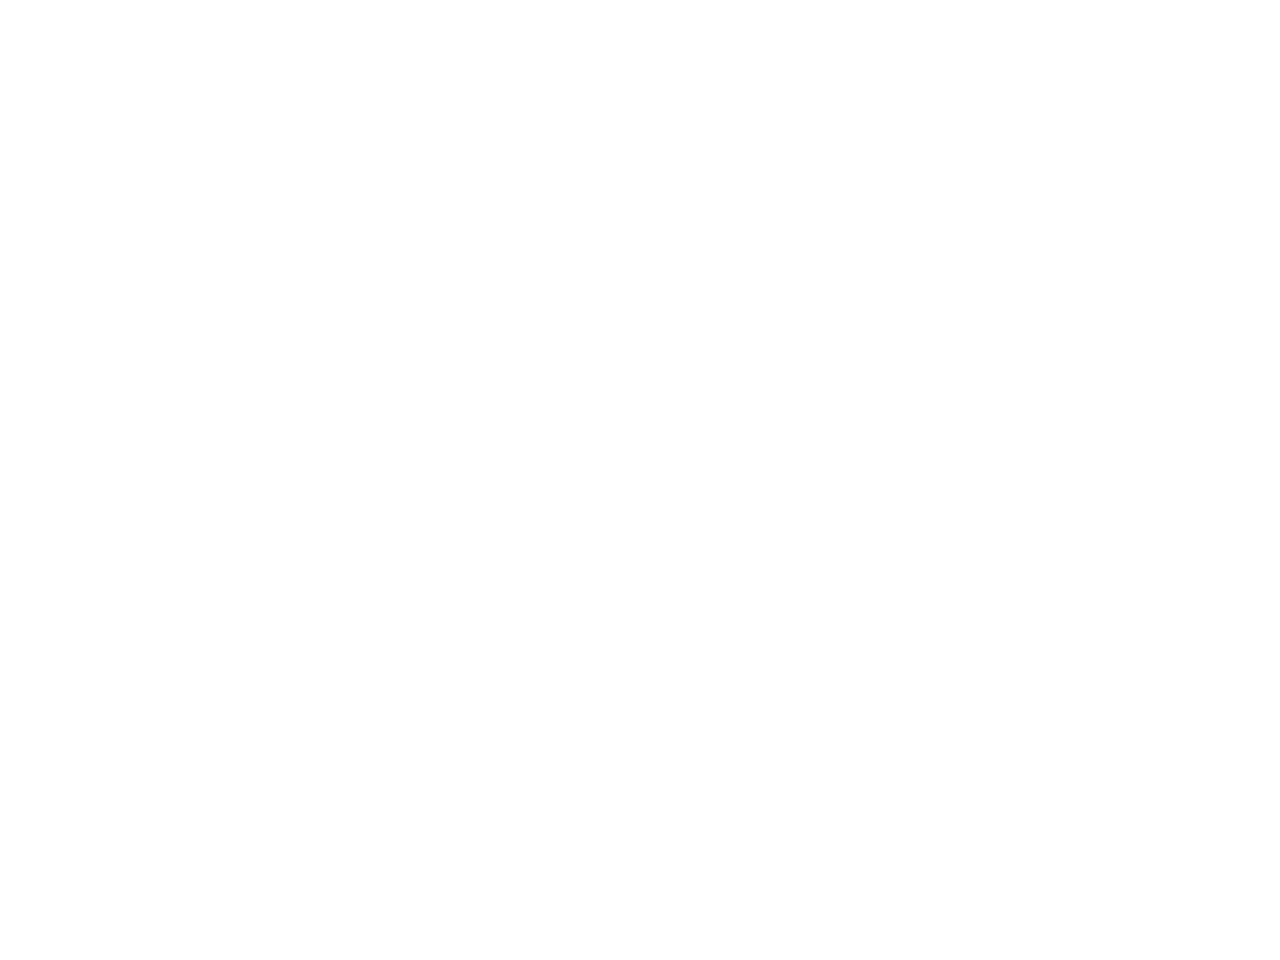

<IPython.core.display.Javascript object>


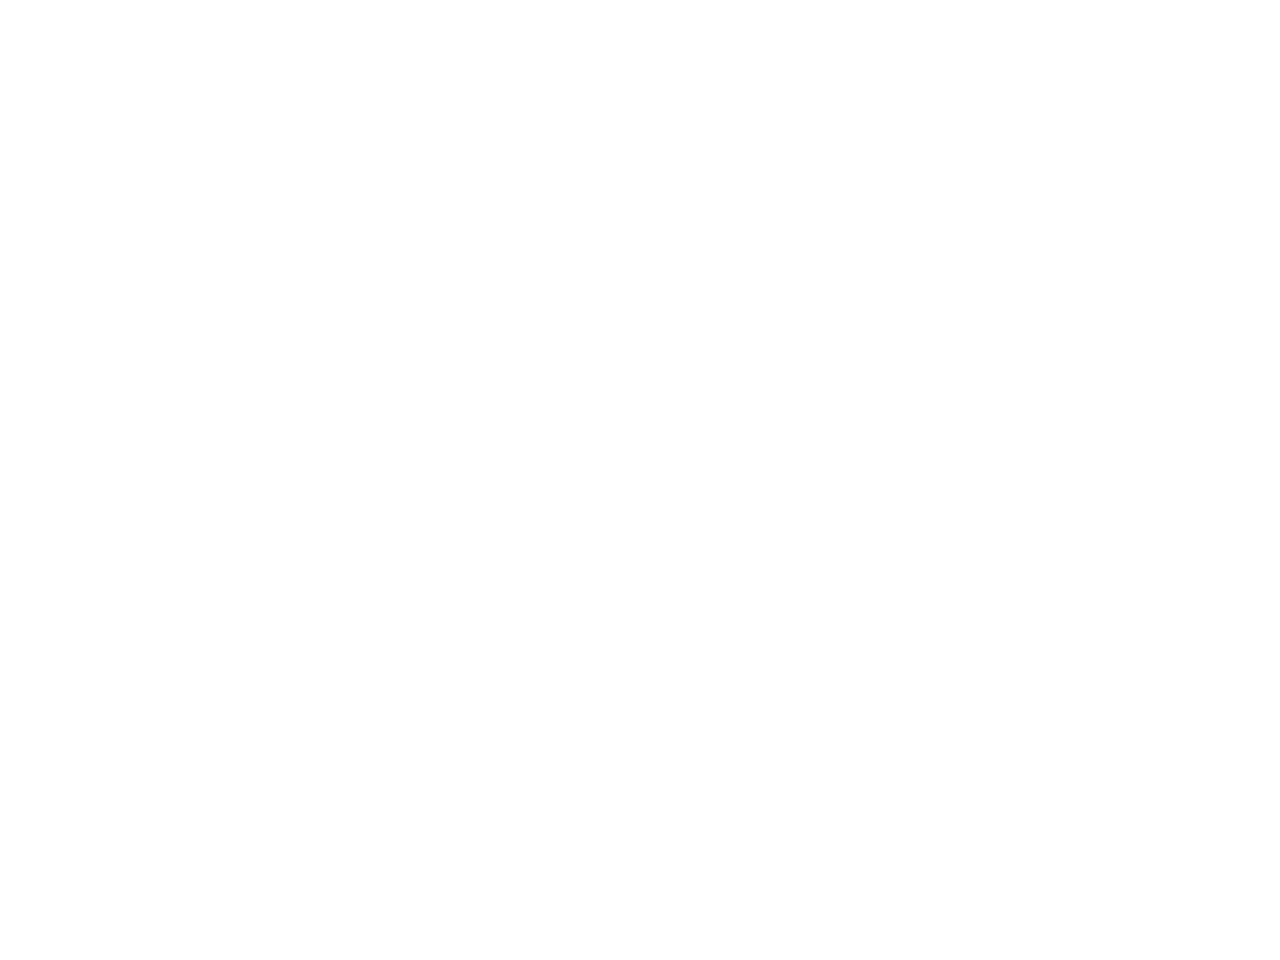

In [23]:
# lab6 = mkMythenCalibration(os.path.join(ROOT, "LaB6_17kev_att2_tth2C_27_01_2018_09-53-59_1588.nxs"),
#                           Calibrant("LaB6"))

plot_peaks(lab6, module=0, index=30, threshold=Threshold(10000))
plot_peaks(lab6, module=0, index=200, threshold=Threshold(10000))

Now we have a method which allow to find all the relevant peaks.

In [47]:
# TODO pouvoir selectionner un pic pour l'affinement.

def calibrationMythen(json: str,
                      params: MythenCalibration,
                      module: int) -> None:
    """Do a calibration with a bunch of images"""

    # Definition of the geometry refinement: the parameter order is
    # the same as the param_names
    calibrant = get_calibrant(params.calibrant,
                              params.wavelength)
    detector = get_detector(Detector('Mythen'))

    (functions, initial_parameters) = params.mythens[module].functions
    parameters = {p.name: p.value for p in initial_parameters}
    bounds = {p.name: p.bounds for p in initial_parameters}
    param_names = [p.name for p in initial_parameters]

    # Let's refine poni1 and poni2 also as function of the distance:

    trans_function = GeometryTransformation(param_names=param_names,
                                            pos_names=["tth2C"],
                                            dist_expr=functions.distance,
                                            poni1_expr=functions.poni1,
                                            poni2_expr=functions.poni2,
                                            rot1_expr=functions.rot1,
                                            rot2_expr=functions.rot2,
                                            rot3_expr=functions.rot3)

    def pos_function(frame: MythenCalibrationFrame) -> Tuple[float]:
        """Definition of the function reading the detector position from the
        header of the image."""
        return (frame.tth2C,)

    gonioref = GoniometerRefinement(parameters,  # initial guess
                                    bounds=bounds,
                                    pos_function=pos_function,
                                    trans_function=trans_function,
                                    detector=detector,
                                    wavelength=params.wavelength)

    print("Empty refinement object:")
    print(gonioref)

    # Let's populate the goniometer refinement object with the indexed peaks.

    with File(params.filename, mode='r') as h5file:
        for frame in gen_metadata_idx_mythen(h5file, params):
            mythen = frame.mythens[module]
            peaks = find_peaks(mythen.data, params.threshold,
                               frame.tth2C, module, calibrant, params.rings)
            if len(peaks) == 0:
                continue
                
            if frame.label in gonioref.single_geometries:
                sg = gonioref.single_geometries[frame.label]
                for peak in peaks:
                    sg.control_points.append([[0, peak.position]], ring=peak.index)
            else:
                cp = ControlPoints(calibrant=calibrant)
                for peak in peaks:
                    cp.append([[0, peak.position]], ring=peak.index)
                data = cp.getList()
                dic = gonioref.get_ai(frame.idx).getPyFAI()
                dic["detector"] = detector
                dic["data"] = array(data)
                dic["calibrant"] = calibrant
                gr = pyFAI.geometryRefinement.GeometryRefinement(**dic)
                sg = gonioref.new_geometry(frame.label,
                                           numpy.atleast_2d(mythen.data),
                                           metadata=frame,
                                           calibrant=calibrant,# control_points=cp, 
                                           geometry=gr)
                sg.control_points = cp
            sg.geometry_refinement.data = numpy.array(sg.control_points.getList())
            # print(sg.geometry_refinement.data)
            
        print("Filled refinement object:")
        # print(gonioref)
        # print(os.linesep + "\tlabel \t tth2C")
        # for k, v in gonioref.single_geometries.items():
        #    print(k, v.get_position())

        #for g in gonioref.single_geometries.values():
        #    ai = gonioref.get_ai(g.get_position())
        #    print(ai)

        #for sg in gonioref.single_geometries.values():
        #    jupyter.display(sg=sg)

        gonioref.refine2()

    #for idx, sg in enumerate(gonioref.single_geometries.values()):
    #    sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)  # noqa
        #jupyter.display(sg=sg)

    gonioref.save(json)

    return gonioref

In [48]:
def calib():
    return [calibrationMythen('calib_{}.json'.format(i), lab6, i)
               for i in range(9)]
        
#%prun calib()
all_gonio = calib()

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .
Filled refinement object:
Cost function before refinement: 0.00193589313756
[  7.20000000e-01   3.20000000e-02   0.00000000e+00  -1.00000000e+00
   8.28000000e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
     fun: 2.8250936036555954e-09
     jac: array([ -4.15732801e-09,   2.09454949e-07,  -2.40399085e-08,
        -5.17261728e-06,   2.38636694e-10,   4.55495609e-08,
         3.81751064e-09,   1.72084569e-14,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 290
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([  7.17431231e-01,   3.86470716e-02,   0.00000000e+00,
        -1.00000000e+00,   8.02913876e+01,  -2.56168414e-02,
        -5.70644077e-05,   0.00000000e+00])
Cost function after refinement: 2.82509360366e-09
GonioParam(dist=0.71743123116670782, poni1=0.038647071585016034, poni2=0.0, rot1_scale=-1.0, rot1_offset=80.291387577763388, rot2_scale=-0.0

In [26]:
# let's plot all the modules
# lab6 = mkMythenCalibration(os.path.join(ROOT, "LaB6_17kev_att2_tth2C_27_01_2018_09-53-59_1588.nxs"),
#                            Calibrant("LaB6"))
# calibrationMythen('test.json', lab6, 0)
# calibrationMythen('test.json', lab6, 1)
# calibrationMythen('test.json', lab6, 2)

In [27]:
offsets = array([80.270160667939251, 74.564267634616286, 68.886410924292917,
                 63.201112936465272, 57.486728229838924, 51.774320696889333,
                 46.067970974288698, 40.385844765765754, 34.688416013441383])

offsets[:-1] - offsets[1:]

array([ 5.70589303,  5.67785671,  5.68529799,  5.71438471,  5.71240753,
        5.70634972,  5.68212621,  5.69742875])

Let's do it again with the final mechanical setup.

<IPython.core.display.Javascript object>


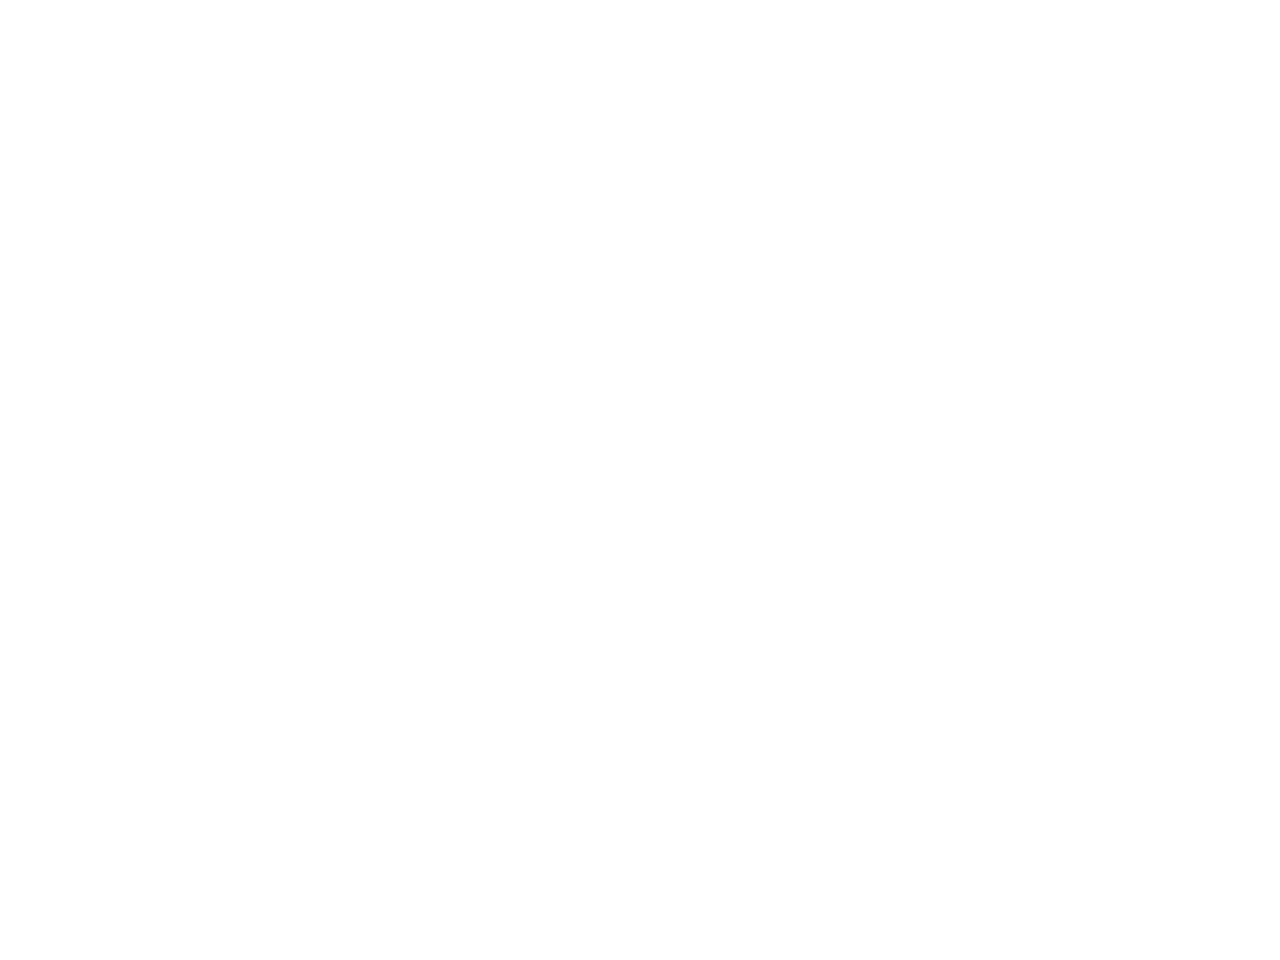

<IPython.core.display.Javascript object>


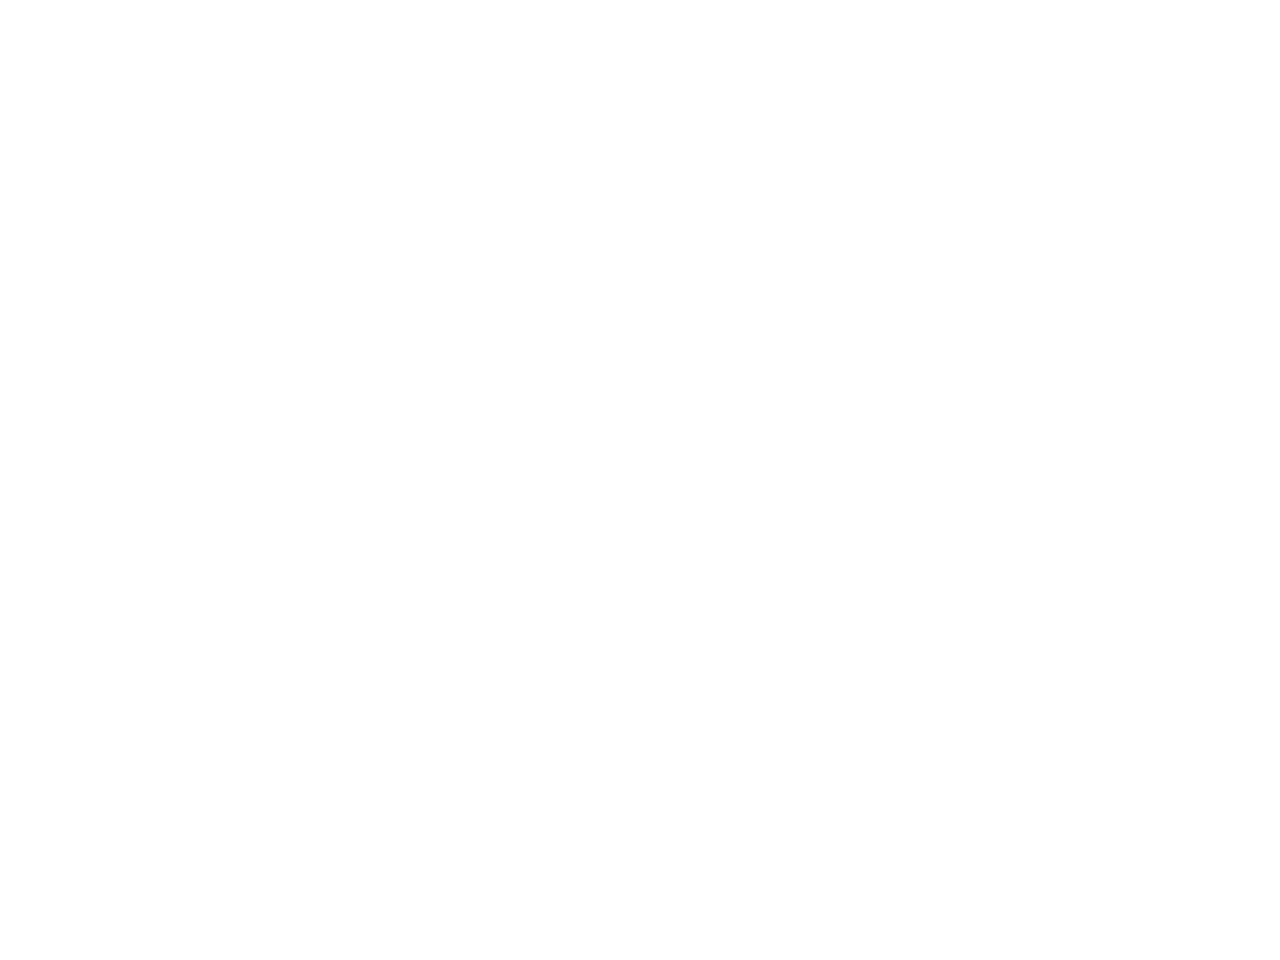

In [28]:
# let's plot all the modules
Parac = mkMythenCalibration(os.path.join(ROOT, "Paracetamol_17keV_tth2C_27_01_2018_16-11-13_1591.nxs"), None)

plot_mythen(Parac)

<IPython.core.display.Javascript object>


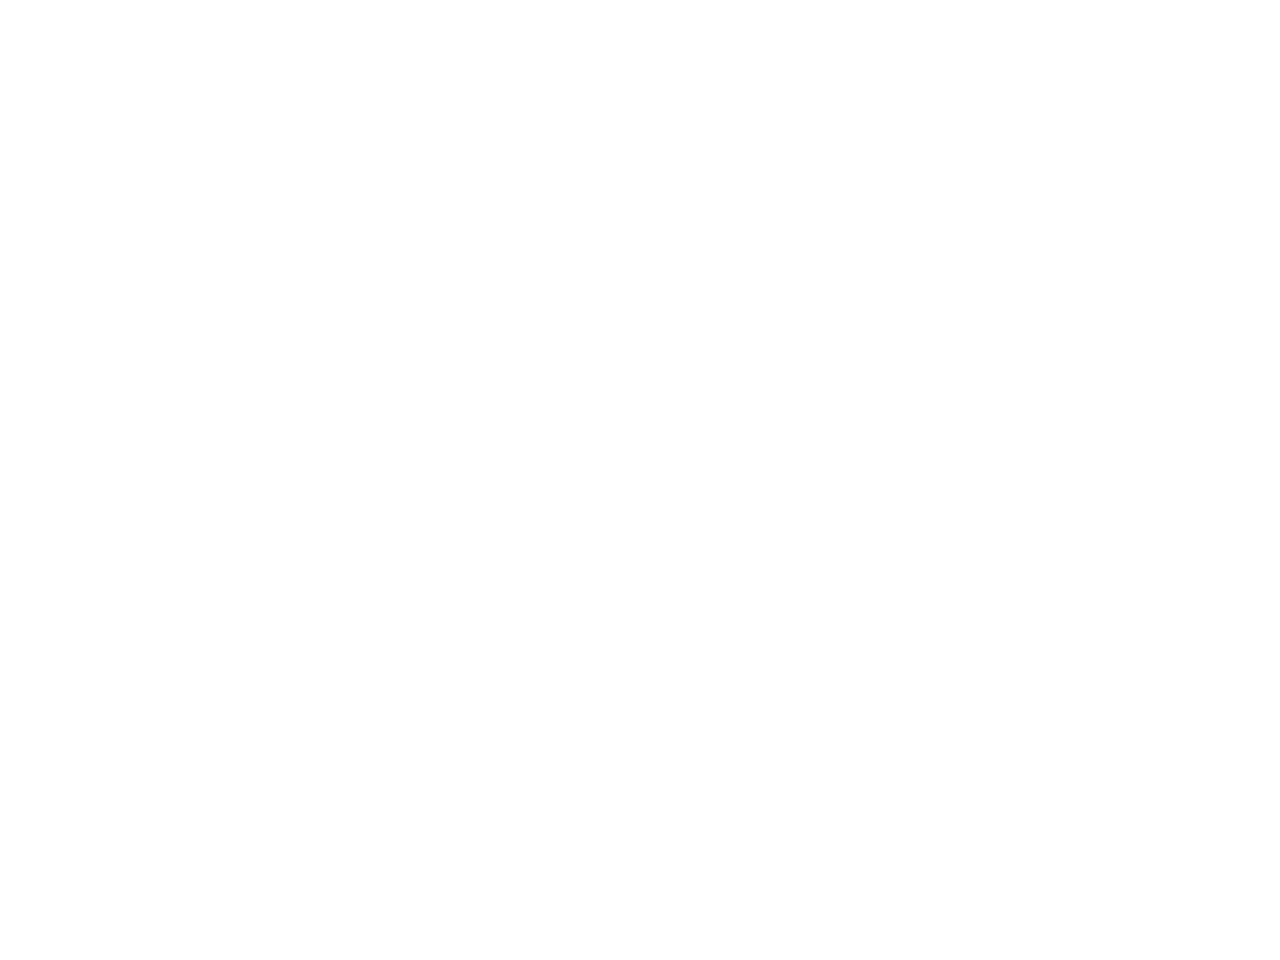

<IPython.core.display.Javascript object>


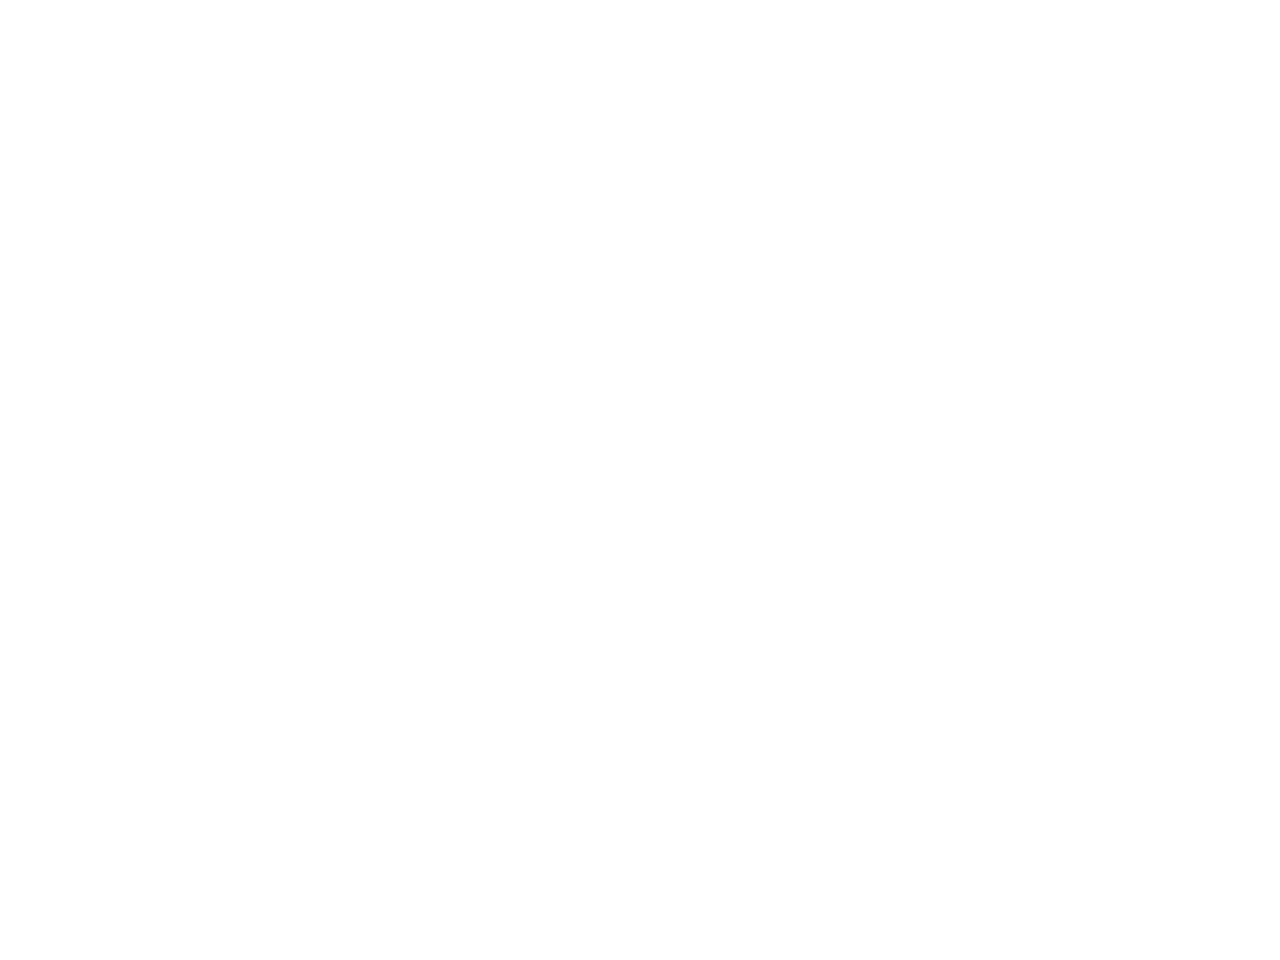

In [29]:
plot_mythen(Parac, modules=(7, 8), xminmax=(26,26.2), yminmax=(750,2200))

In [30]:
from scipy.interpolate import interp1d
from scipy.optimize import bisect

def calc_fwhm(integrate_result, calibrant):
    "calculate the tth position and FWHM for each peak"
    delta = integrate_result.intensity[1:] - integrate_result.intensity[:-1]
    maxima = numpy.where(numpy.logical_and(delta[:-1]>0, delta[1:]<0))[0]
    minima = numpy.where(numpy.logical_and(delta[:-1]<0, delta[1:]>0))[0]
    maxima += 1
    minima += 1
    tth = []
    FWHM = []
    for tth_rad in calibrant.get_2th():
        tth_deg = tth_rad*integrate_result.unit.scale
        if (tth_deg<=integrate_result.radial[1]) or (tth_deg>=integrate_result.radial[-2]):
            continue
        idx_theo = abs(integrate_result.radial-tth_deg).argmin()
        id0_max = abs(maxima-idx_theo).argmin()
        id0_min = abs(minima-idx_theo).argmin()
        I_max = integrate_result.intensity[maxima[id0_max]]
        I_min = integrate_result.intensity[minima[id0_min]]
        tth_maxi = integrate_result.radial[maxima[id0_max]]
        
        I_thres = (I_max + I_min)/2.0
        if minima[id0_min]>maxima[id0_max]:
            if id0_min == 0:
                min_lo = integrate_result.radial[0]
            else:
                min_lo = integrate_result.radial[minima[id0_min-1]]
            min_hi = integrate_result.radial[minima[id0_min]]
        else:
            if id0_min == len(minima) -1:
                min_hi = integrate_result.radial[-1]
            else:
                min_hi = integrate_result.radial[minima[id0_min+1]]
            min_lo = integrate_result.radial[minima[id0_min]]

        f = interp1d(integrate_result.radial, integrate_result.intensity-I_thres)
        try:
            tth_lo = bisect(f, min_lo, tth_maxi)
            tth_hi = bisect(f, tth_maxi, min_hi)
        except Exception as e:
            print(e)
        else:
            FWHM.append(tth_hi-tth_lo)
            tth.append(tth_deg)
    return tth, FWHM

In [31]:
def plot_calibrated_mythen(calibration: MythenCalibration,
                           modules: Iterable[int]=None,
                           json_template: Text=None,
                           xminmax: Tuple[float, float]=None,
                           yminmax: Tuple[float, float]=None,
                           masked: bool=False):
    """Plot the mythen spectra per modules"""
    if modules is None:
        modules = range(len(calibration.mythens))

    if json_template is None:
        json_template = "calib_{}.json"

    with File(calibration.filename) as f:
        
        calibrant = get_calibrant(calibration.calibrant, calibration.wavelength)
        print(calibrant)
        
        nrows = math.ceil(len(modules) / 3)
        ncols = len(modules) if len(modules) < 3 else 3
        fig, axes = pyplot.subplots(nrows, ncols, sharex=True, sharey=True)
        fig2, axes2 = pyplot.subplots(nrows, ncols, sharex=True, sharey=True)
        
        gonios = [pyFAI.goniometer.Goniometer.sload(json_template.format(m))
                  for m in modules]

        tths_m = [[] for m in modules]
        spectra_m = [[] for m in modules]

        for frame in gen_metadata_idx_mythen(f, calibration):
            for mi, m in enumerate(modules):
                tths_m[mi].append(frame.tth2C)
                mythen = frame.mythens[m]
                spectra_m[mi].append(numpy.atleast_2d(mythen.data))

        for i, (gonio, tths, spectra, m) in enumerate(zip(gonios, tths_m, spectra_m, modules)):
            mai = gonio.get_mg(tths)
            mai.radial_range = (0, 100)
            res = mai.integrate1d(spectra, 25000)
            axis = axes.flat[0]
            axis.set_title(str(m))
            ax_xrpd_1d = axis.plot(res[0], res[1])
            
            fwhm = calc_fwhm(res, calibrant)
            axis2 = axes2.flat[i]
            axis2.set_title("FWHM "+str(m))
            axis2.plot(*fwhm)
            print(ax_xrpd_1d)
            for x in fwhm[0]:
                print(x, axis.get_ybound())
                line = matplotlib.lines.Line2D([x, x], axis.get_ybound() , color='red', linestyle='--', axes=axis)
    return  res, calibrant

In [32]:
def plot_calibrated_mythen_all(calibration: MythenCalibration,
                           modules: Iterable[int]=None,
                           json_template: Text=None,
                           xminmax: Tuple[float, float]=None,
                           yminmax: Tuple[float, float]=None,
                           masked: bool=False):
    """Plot the mythen spectra per modules"""
    if modules is None:
        modules = range(len(calibration.mythens))

    if json_template is None:
        json_template = "calib_{}.json"

    with File(calibration.filename) as f:
        
        calibrant = get_calibrant(calibration.calibrant, calibration.wavelength)
        print(calibrant)
  
        base_mask = numpy.zeros(detector.shape, dtype="int8")
        base_mask[0, :20] = 1
        base_mask[0, -20:] = 1

        fig, axes = pyplot.subplots(1, 1, sharex=True, sharey=True)
        fig2, axes2 = pyplot.subplots(1, 1, sharex=True, sharey=True)
        
        gonios = [pyFAI.goniometer.Goniometer.sload(json_template.format(m))
                  for m in modules]

        for gonio in gonios:
            gonio.detector.mask = base_mask

        tths_m = [[] for m in modules]
        spectra_m = [[] for m in modules]

        for frame in gen_metadata_idx_mythen(f, calibration):
            for mi, m in enumerate(modules):
                tths_m[mi].append(frame.tth2C)
                mythen = frame.mythens[m]
                spectra_m[mi].append(numpy.atleast_2d(mythen.data))
        #cnt_sum = None
        mgs = []
        for i, (gonio, tths, spectra, m) in enumerate(zip(gonios, tths_m, spectra_m, modules)):
            
            mai = gonio.get_mg(tths)
            mai.radial_range = (0, 100)
            res = mai.integrate1d(spectra, 25000)
            axis = axes
            axis.set_title(str(m))
            axis.plot(res[0], res[1], label=str(i))
            print(res)
            #fwhm = calc_fwhm(res, calibrant)
            #axis2 = axes2
            #axis2.set_title("FWHM "+str(m))
            #axis2.plot(*fwhm)
            mgs.append(mai)
            #for x in fwhm[0]:
            #    print(x, axis.get_ybound())
            #    line = matplotlib.lines.Line2D([x, x], axis.get_ybound() , color='red', linestyle='--', axes=axis)
        axes.legend()
    return  res, calibrant, mgs

LaB6_SRM660a Calibrant at wavelength 7.287e-11


<IPython.core.display.Javascript object>


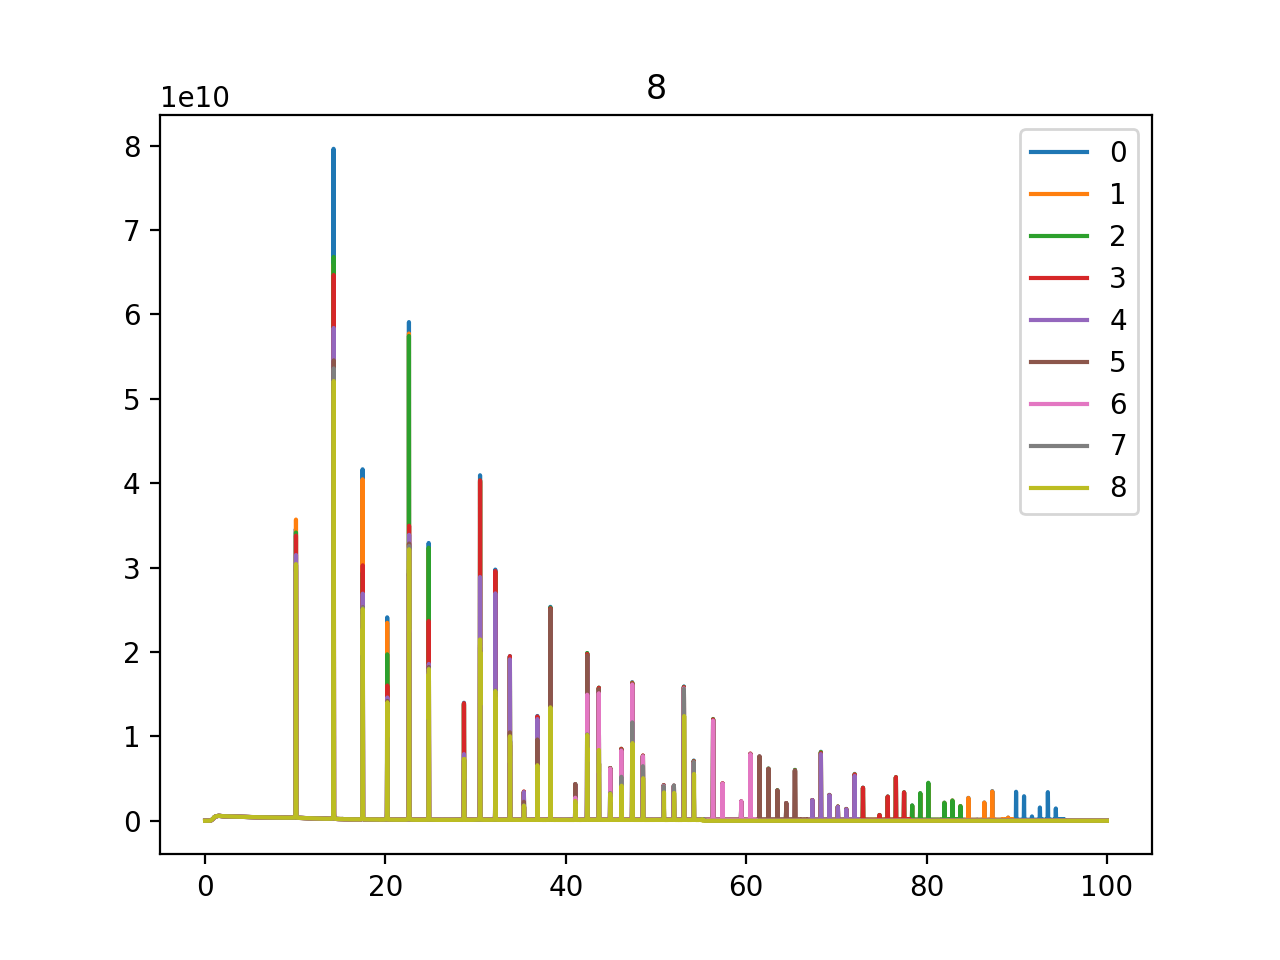

<IPython.core.display.Javascript object>


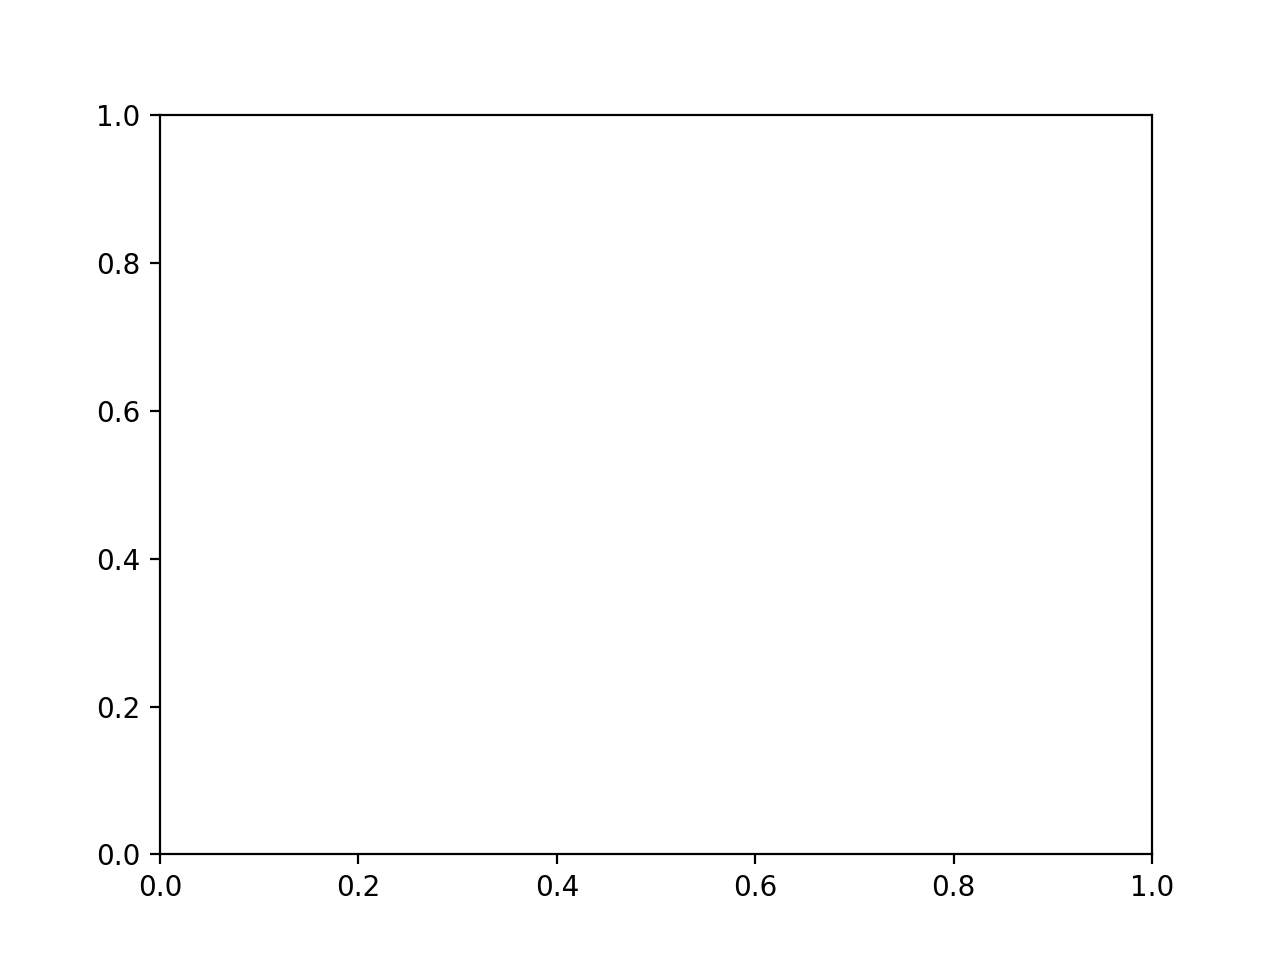

(array([  2.00000024e-03,   6.00000024e-03,   1.00000002e-02, ...,
         9.99900000e+01,   9.99940000e+01,   9.99980000e+01]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))
(array([  2.00000024e-03,   6.00000024e-03,   1.00000002e-02, ...,
         9.99900000e+01,   9.99940000e+01,   9.99980000e+01]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))
(array([  2.00000024e-03,   6.00000024e-03,   1.00000002e-02, ...,
         9.99900000e+01,   9.99940000e+01,   9.99980000e+01]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))
(array([  2.00000024e-03,   6.00000024e-03,   1.00000002e-02, ...,
         9.99900000e+01,   9.99940000e+01,   9.99980000e+01]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))
(array([  2.00000024e-03,   6.00000024e-03,   1.00000002e-02, ...,
         9.99900000e+01,   9.99940000e+01,   9.99980000e+01]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))
(array([  2.00000024e-03,   6.00000024e-03,   1.00000002e-02, ...,
         9.99900000e+01,   9.99940000e+01,   9.99980000e+01]), 

In [44]:
%matplotlib notebook
res, calibrant, mgs =plot_calibrated_mythen_all(lab6, list(range(9)))
pyplot.show()

In [34]:
f = calc_fwhm(res, calibrant)


<IPython.core.display.Javascript object>


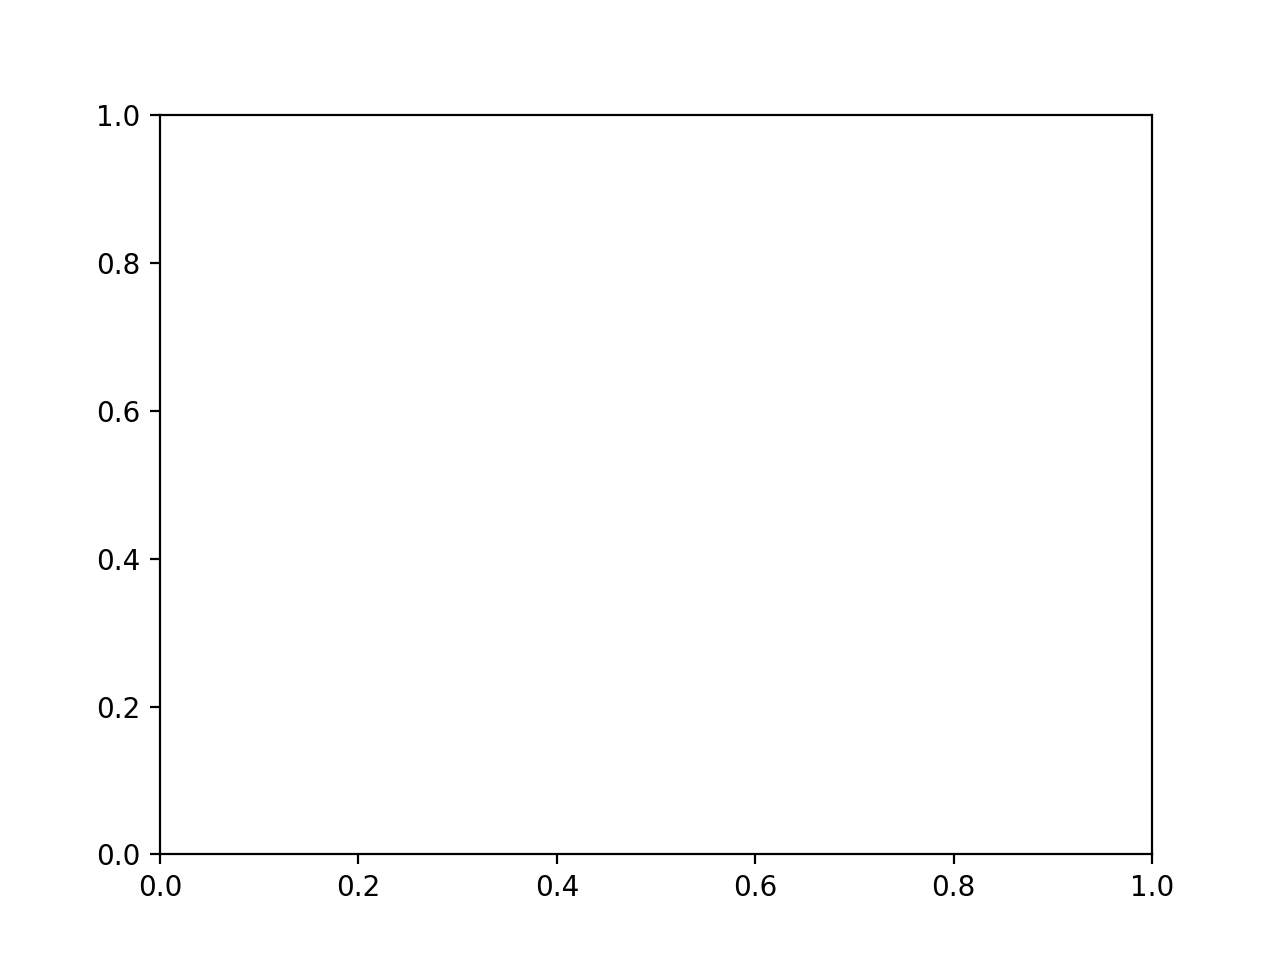

(0.0, 1.0)

In [37]:
f, a = pyplot.subplots()
a.get_ybound()

